In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100) # Set Number of Columns to view

import numpy as np
import scipy as sp

# Statsmodels
import statsmodels.api as sm

In [2]:
# Correlation calculations
def corr_calculation(df, pairs, corr_method, value):
    '''
    Function to calculate correlation.
    Input
    df: dataframe, 
    pairs: tuple of pairs,
    corr_method: 'pearson' or 'kendall', 
    value: float between 0 and 1 to filter corr values
    '''
    count = 0
    for (r, f) in pairs:
        try:
            corr = df[r].corr(df[f], method = corr_method)
            if not '_Prgm_' in f and abs(corr) > value:
                print 'Correlation between "{}" and "{}" = {}'.format(r, f, corr)
                print '-----------------------------------------------------------------------------------------------'
        except TypeError as e:
            count += 1
            print '**********************************************************************************************'
            print 'Error count: "{}". "{}" and "{}" giving error: "{}"'.format(count, r, f, e)
            print '**********************************************************************************************'

## Feature Engineering

- Feature discretization
- Voter Index - https://www.minnpost.com/data/2012/04/calculating-political-lean-new-legislative-districts
- Travel Time Index
- Crime Index
- Voter Registration Rate = # Registered/Population

In [3]:
# Load data
data = pd.read_csv('clean_data.csv')

# Create a list of cloumns that are in data
data_cols = data.columns.tolist()

## <font color=green>Ethnic Diversity Index</font>

Reference[1]: http://www.unc.edu/~pmeyer/carstat/tools.html

Reference[2]: James D. Fearon (2013). Ethnic and Cultural Diversity by Country. Journal of Economic Growth, 8, pp195-222.

- Most commonly employed measure of aggregate ethnic diversity is fractionalization.
- Fractionalization is defined as probability that two individuals selected at random from a country will be from different ethnic group.

> If the population proportions of the ethnic groups in a country are denoted as $p_1, p_2, p_3, ..., p_n$, then fractionalization is $F = 1 - \sum_{i=1}^{n}p^2_i$

- The average value of 0.48 for all countries implies that if one were to select a country at random, then randomly select two people from it, there is about a 50-50 chance that they would come from different ethnic groups

---
- 'PopulationR' : <font color=#de2d26>Delete</font>
- 'TotalPopulationOfOneRace' = White + BlackOrAfricanAmerican + AmericanIndianAndAlaskaNative + TotalAsian + TotalNHOPI + SomeOtherRace : <font color=#de2d26>Delete</font>
- 'White',
- 'BlackOrAfricanAmerican',
- 'AmericanIndianAndAlaskaNative',
- 'TotalAsian' = AsianIndian + Chinese + Filipino + Japanese + Korean + Vietnamese + OtherAsian : <font color=#de2d26>Delete</font>
- 'AsianIndian',
- 'Chinese',
- 'Filipino',
- 'Japanese',
- 'Korean',
- 'Vietnamese',
- 'OtherAsian',
- 'TotalNHOPI' = NativeHawaiian	+ GuamanianOrChamorro + Samoan + OtherPacificIslander: <font color=#de2d26>Delete</font>
- 'NativeHawaiian',
- 'GuamanianOrChamorro',
- 'Samoan',
- 'OtherPacificIslander',
- 'SomeOtherRace',
- **New Column:** 'TotalPopulationofTwoOrMoreRaces' = Population - TotalPopulationOfOneRace

In [4]:
# Calculate Total Population of Two or More Races
data['TotalPopulationofTwoOrMoreRaces'] = data['Population'] - data['TotalPopulationOfOneRace']

# Calculate Diversity Index
data['Diversity_Index'] = 1 - ((data['White']/data['PopulationR'])**2 
                                + (data['BlackOrAfricanAmerican']/data['PopulationR'])**2 
                                + (data['AmericanIndianAndAlaskaNative']/data['PopulationR'])**2 
                                + (data['AsianIndian']/data['PopulationR'])**2 
                                + (data['Chinese']/data['PopulationR'])**2 
                                + (data['Filipino']/data['PopulationR'])**2 
                                + (data['Japanese']/data['PopulationR'])**2 
                                + (data['Korean']/data['PopulationR'])**2 
                                + (data['Vietnamese']/data['PopulationR'])**2 
                                + (data['OtherAsian']/data['PopulationR'])**2 
                                + (data['NativeHawaiian']/data['PopulationR'])**2 
                                + (data['GuamanianOrChamorro']/data['PopulationR'])**2 
                                + (data['Samoan']/data['PopulationR'])**2 
                                + (data['OtherPacificIslander']/data['PopulationR'])**2 
                                + (data['SomeOtherRace']/data['PopulationR'])**2 
                                + (data['TotalPopulationofTwoOrMoreRaces']/data['PopulationR'])**2)

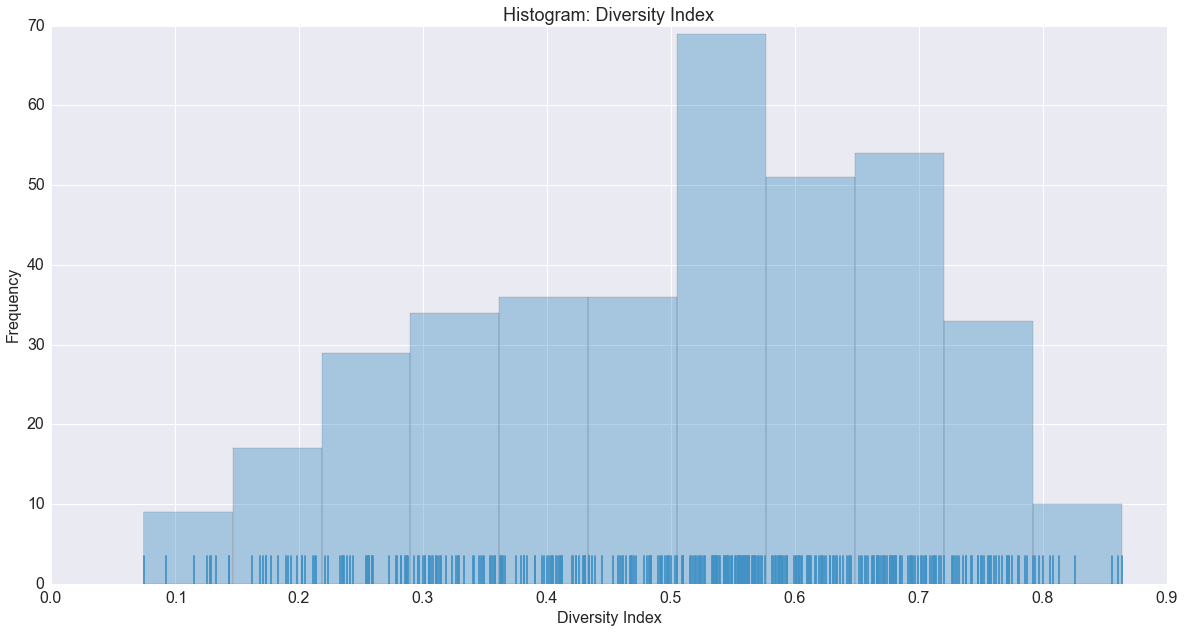

In [5]:
# Histogram: Diversity Index
temp = data['Diversity_Index']

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Diversity Index', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Diversity Index', fontsize = 18)

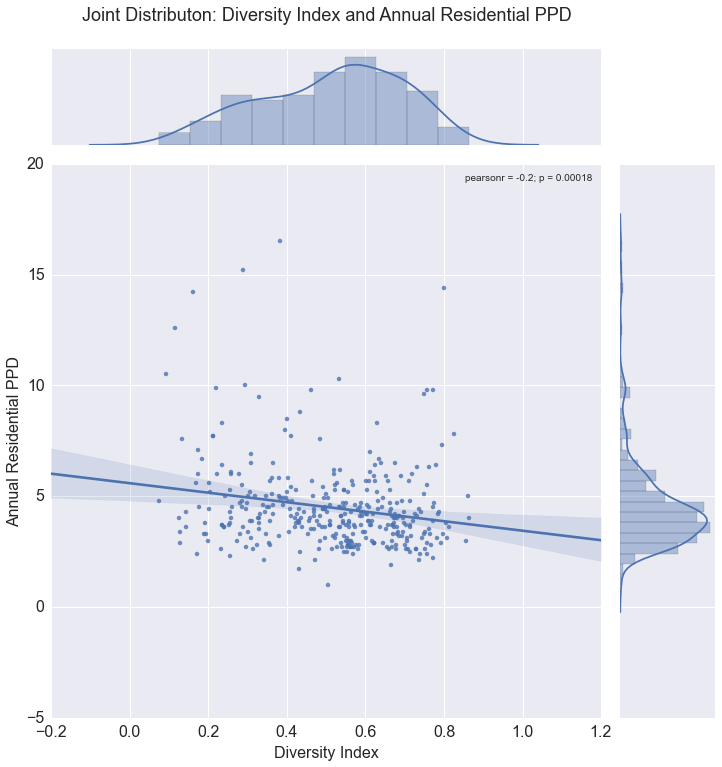

In [6]:
# Joint Distribution: Diversity Index and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Diversity_Index']]
temp = temp[temp['Annual_ResPPD_2013'] < 20] # Dropped outliers

# z-score Normalize Y
#temp['Annual_ResPPD_2013'] =  (temp['Annual_ResPPD_2013'] - temp['Annual_ResPPD_2013'].mean(axis = 0))/temp['Annual_ResPPD_2013'].std(axis = 0)

sns.jointplot('Diversity_Index', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Diversity Index', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Diversity Index and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: If < 50 or 100 used, corr = -0.13, and if < 20 used corr = -0.2 (without z-score also!)

## <font color=green>Voter Registration Rate</font>


$$Rate_i = \frac{\#\;Registered_i}{Population_i}$$, where $i$ is Jurisdiction

In [7]:
data['Voter_Registration_Rate'] = data['Tot_Registered_2013']/data['Population']

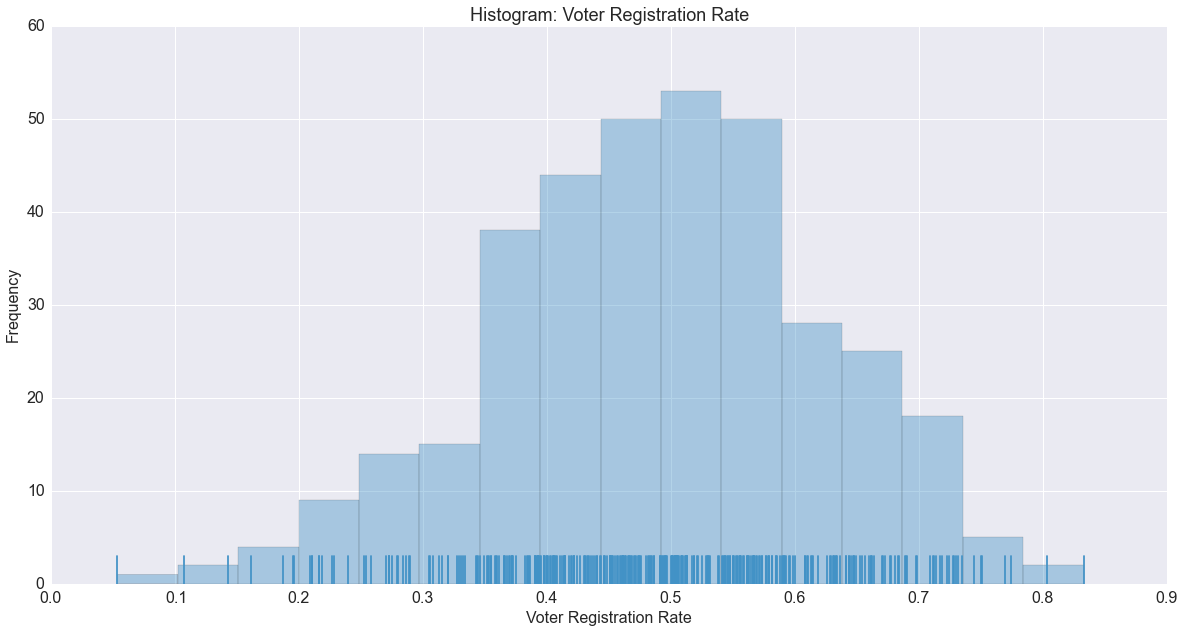

In [8]:
# Histogram: Voter Registration Rate
temp = data[['Voter_Registration_Rate']]

# Voter Registration Rate should be between 0 and 1. # Registered/Population can not be > 1
temp = temp[temp['Voter_Registration_Rate'] < 1]

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Voter Registration Rate', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Voter Registration Rate', fontsize = 18)

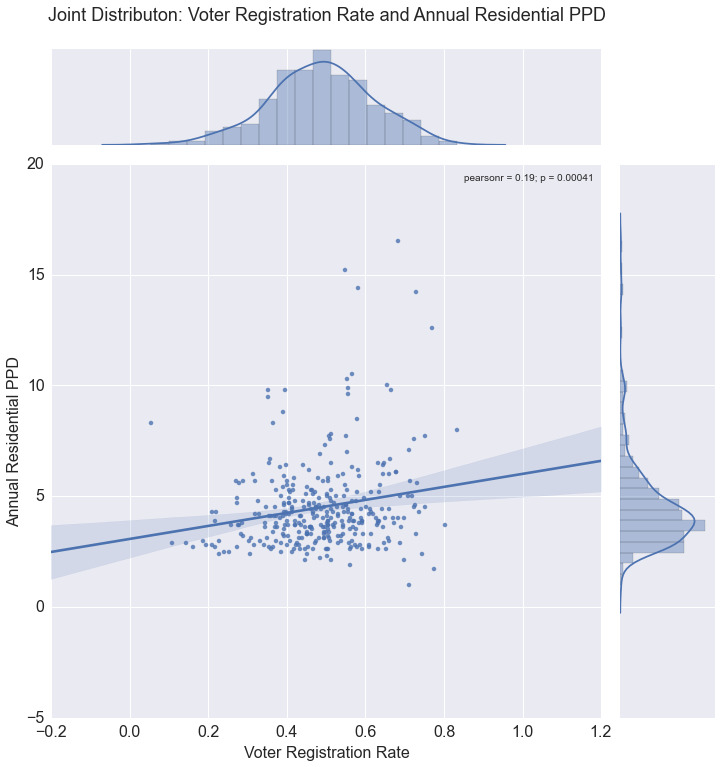

In [9]:
# Joint Distribution: Voter Registration Rate and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Voter_Registration_Rate']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20) & (temp['Voter_Registration_Rate'] < 1)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Voter_Registration_Rate', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Voter Registration Rate', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Voter Registration Rate and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: If Res < 50 or 100 used, corr = -0.037, and if Res < 20 and VRR < 1 used corr = 0.19 (without z-score also!)

## <font color=green>Republican to Democratic Ratio</font>

- Republican Democratic Ratio = $\frac{Republican \; Registered}{Democratic \; Registered}$

In [10]:
data['Rep_Dem_Ratio'] = data['Republican_2013']/data['Democratic_2013']

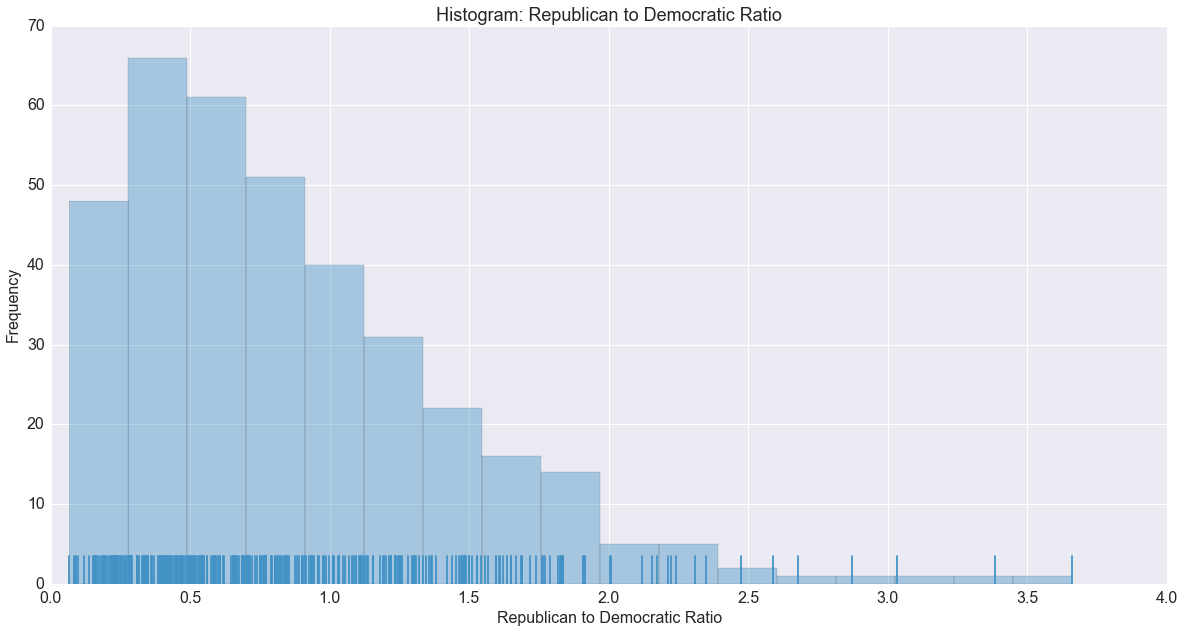

In [11]:
# Histogram: Republican to Democratic Ratio
temp = data[['Rep_Dem_Ratio']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Republican to Democratic Ratio', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Republican to Democratic Ratio', fontsize = 18)

## Use Log

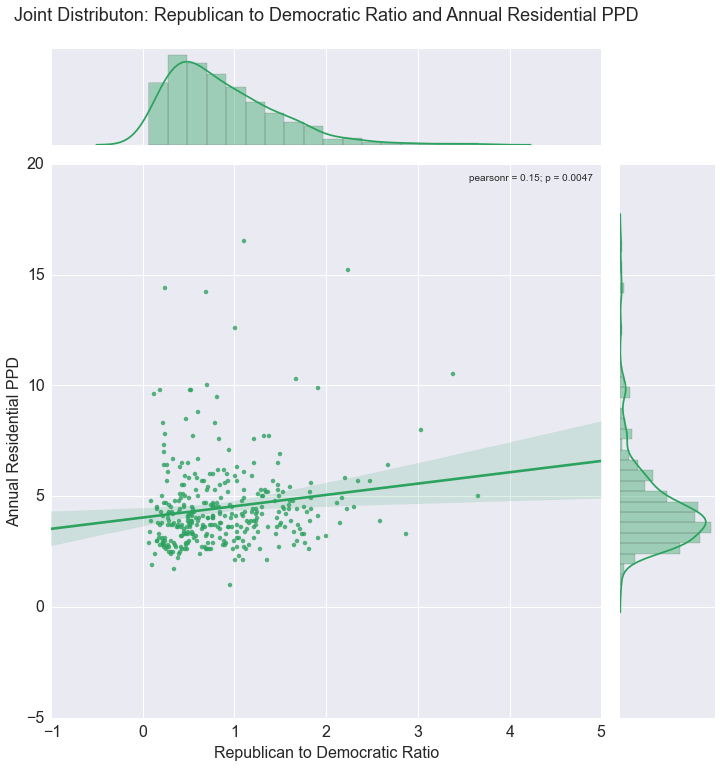

In [12]:
# Joint Distribution: Republican to Democratic Ratio and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Rep_Dem_Ratio']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)]# Dropped outliers 

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Rep_Dem_Ratio', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10, color = '#2ca25f')
plt.xlabel('Republican to Democratic Ratio', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Republican to Democratic Ratio and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: If Res < 50 or 100 used, corr = 0.051, and if Res < 20 used corr = 0.15 (without z-score also!)

## <font color=red>% No Preference</font>

In [13]:
data['Percent_No_Preference'] = data['No_Preference_2013']*100/data['Tot_Registered_2013']

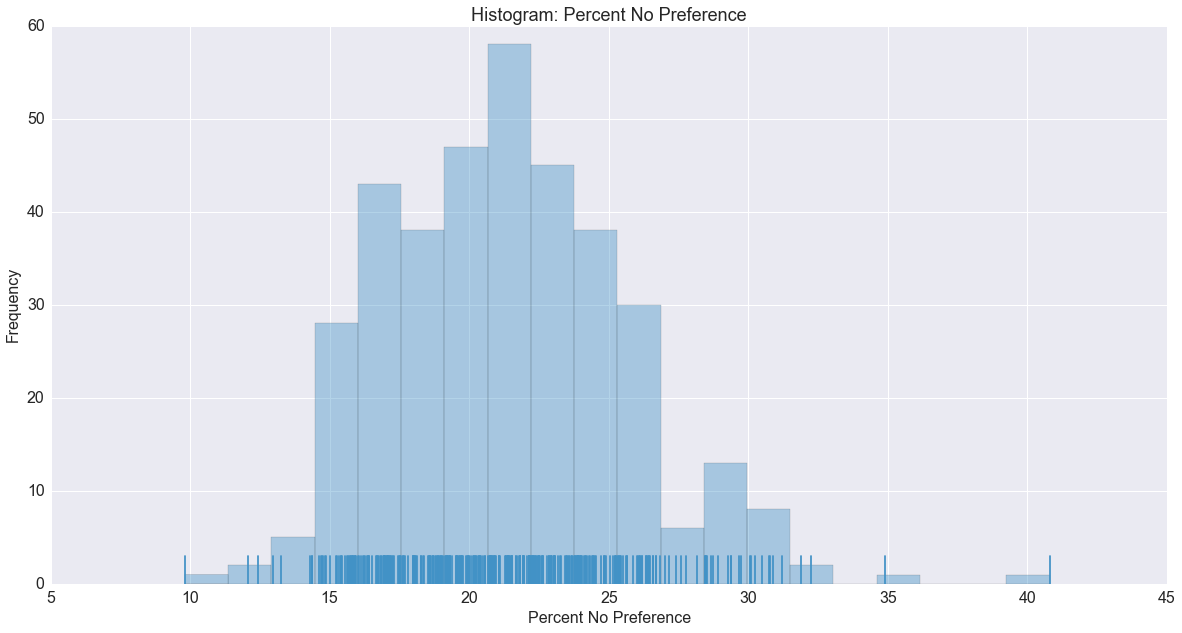

In [14]:
# Histogram: Percent No Preference
temp = data[['Percent_No_Preference']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Percent No Preference', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Percent No Preference', fontsize = 18)

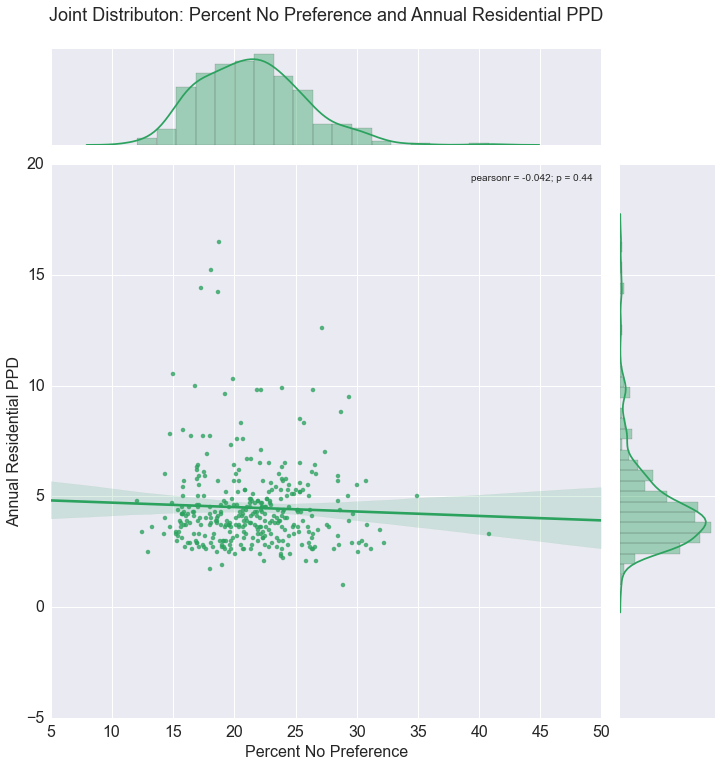

In [15]:
# Joint Distribution: Percent No Preference and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Percent_No_Preference']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)]# Dropped outliers 

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Percent_No_Preference', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10, color = '#2ca25f')
plt.xlabel('Percent No Preference', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Percent No Preference and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: If Res < 50 or 100 used, corr = 0.051, and if Res < 20 used corr = 0.15 (without z-score also!)

## <font color=green>Major Crime to Minor Crime Ratio</font>

In [16]:
# Correct Total Crime Column: Violent was added to get Total Crime
data['TotCrimes_2013'] = (data['Homicide_2013'] + data['Rape_2013'] + data['Robbery_2013'] 
                          + data['Assault_2013'] + data['Property_2013'] + data['Burglary_2013'] 
                          + data['VehicleTheft_2013'] + data['Larceny_2013'] + data['Arson_2013'])

In [17]:
data['Major_Minor_Crime_Ratio'] = data['Violent_2013']/(data['TotCrimes_2013'] - data['Violent_2013'])

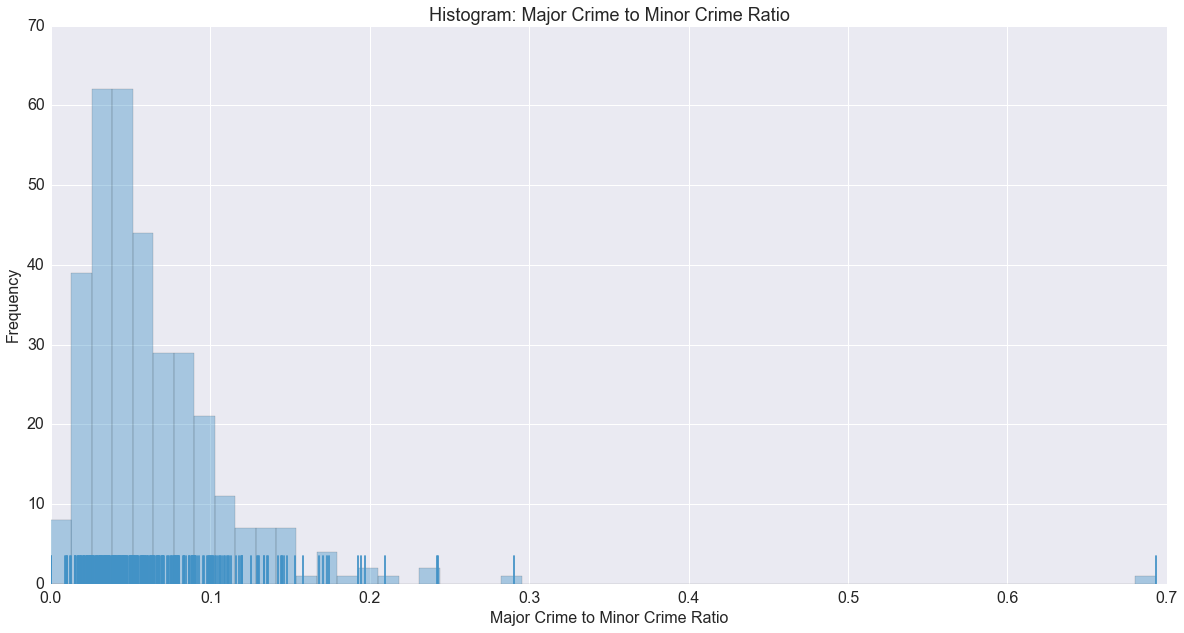

In [18]:
# Histogram: Major Crime to Minor Crime Ratio
temp = data[['Major_Minor_Crime_Ratio']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Major Crime to Minor Crime Ratio', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Major Crime to Minor Crime Ratio', fontsize = 18)

## Use log

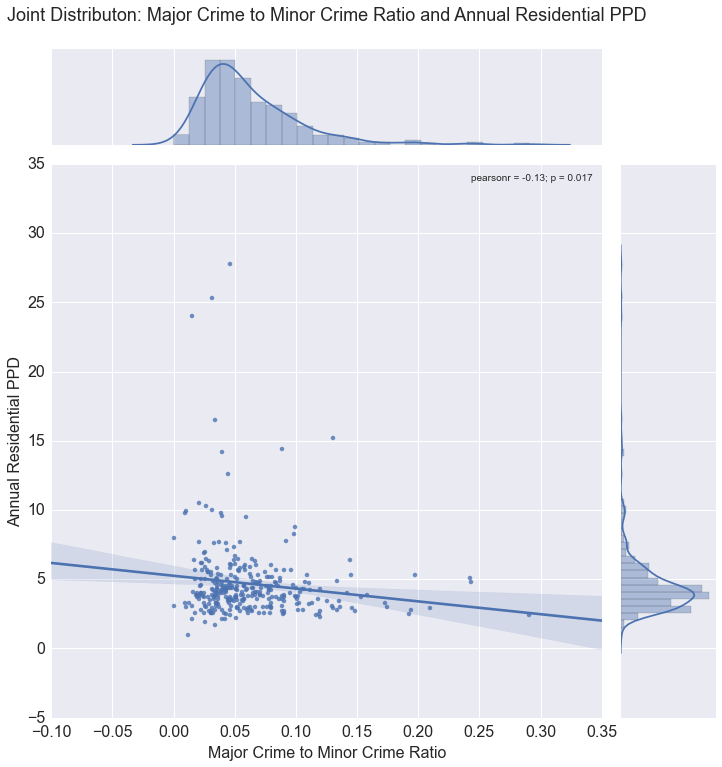

In [19]:
# Joint Distribution: Major Crime to Minor Crime Ratio and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Major_Minor_Crime_Ratio']]
temp = temp[(temp['Annual_ResPPD_2013'] < 100) & (temp['Major_Minor_Crime_Ratio'] < 0.5)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Major_Minor_Crime_Ratio', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Major Crime to Minor Crime Ratio', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Major Crime to Minor Crime Ratio and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: If Res < 50 or 100 used MMCR < 0.5, corr = -0.13, and if Res < 20 and MMCR < 0.5 used corr = -0.12 (without z-score also!)

## <font color=green>Percent Violent Crime</font>

In [20]:
data['Percent_Violent'] = data['Violent_2013']*100/data['TotCrimes_2013']

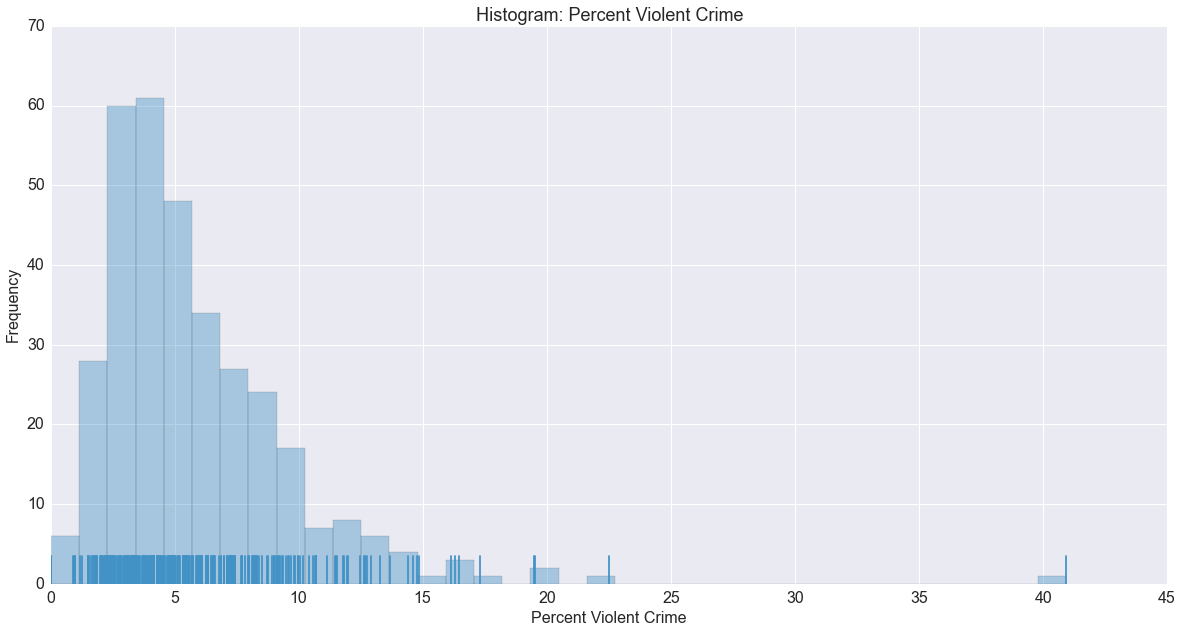

In [21]:
# Histogram: Percent Violent Crime
temp = data[['Percent_Violent']] 
plt.figure(figsize = (20, 10))
sns.distplot(temp['Percent_Violent'].dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Percent Violent Crime', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Percent Violent Crime', fontsize = 18)

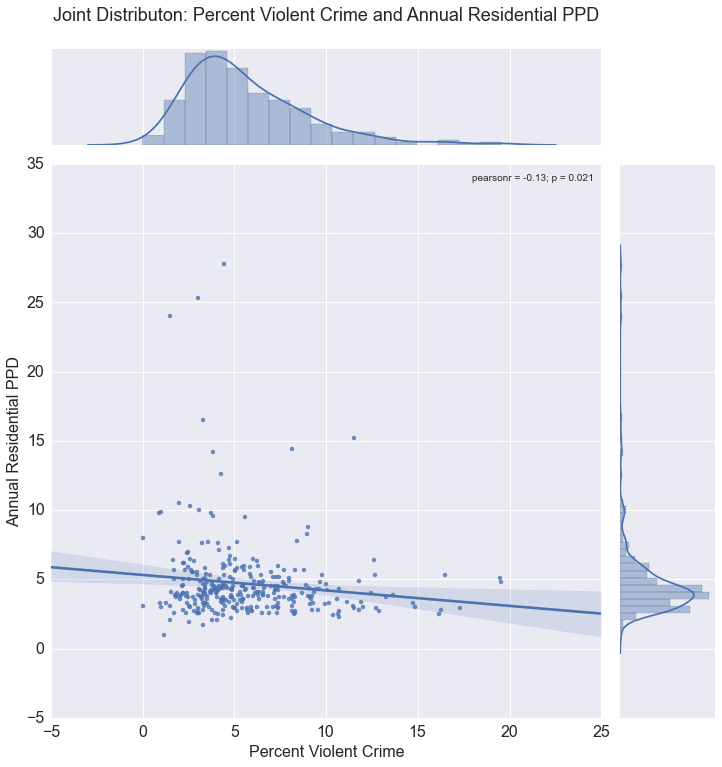

In [22]:
# Joint Distribution: Percent Violent Crime and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Percent_Violent']]
temp = temp[(temp['Annual_ResPPD_2013'] < 100) & (temp['Percent_Violent'] < 20)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Percent_Violent', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Percent Violent Crime', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Percent Violent Crime and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: If Res < 50 or 100 used MMCR < 0.5, corr = -0.13, and if Res < 20 and MMCR < 0.5 used corr = -0.12 (without z-score also!)

## <font color=green>Total Crime/1000 Inhabitants</font>

In [23]:
data['TotCrime/1000People'] = data['TotCrimes_2013']*1000/data['Population']

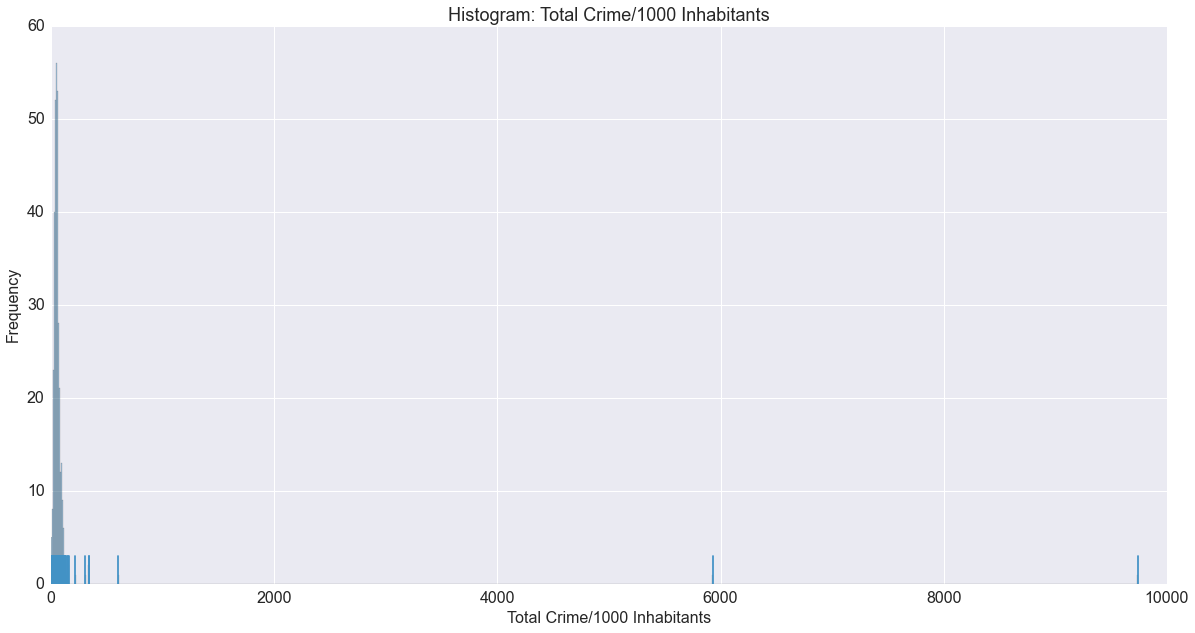

In [24]:
# Histogram: Total Crime/1000 Inhabitants
temp = data[['TotCrime/1000People']] 
plt.figure(figsize = (20, 10))
sns.distplot(temp['TotCrime/1000People'].dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Total Crime/1000 Inhabitants', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Total Crime/1000 Inhabitants', fontsize = 18)

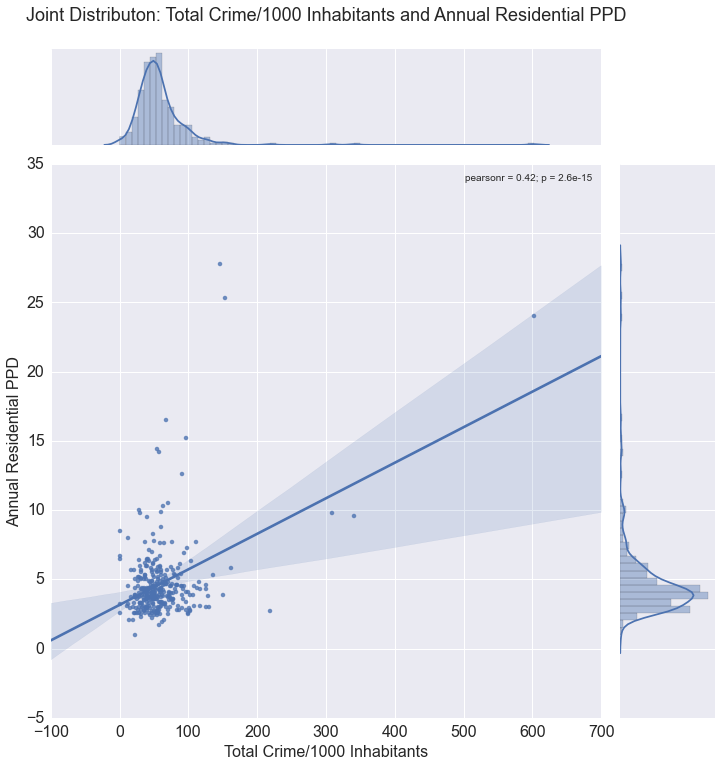

In [25]:
# Joint Distribution: Total Crime/1000 Inhabitants and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'TotCrime/1000People']]
temp = temp[(temp['Annual_ResPPD_2013'] < 50)]# & (temp['TotCrime/Pop'] < 200)] # Dropped outliers
#temp = temp[(temp['TotCrime/Pop'] < 200)] # Dropped outliers


# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('TotCrime/1000People', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Total Crime/1000 Inhabitants', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Total Crime/1000 Inhabitants and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: No dropping of outliers: corr = 0.73 and good p-val, If Res < 50 or 100, corr = 0.42, 
# and if Res < 20 and TC/P < 200 used corr = 0.063  and bad p-val

## <font color=green>Crime Index</font> 

$$C_j = \frac{\sum_i f_i w_i}{Population_j} k$$, where $j$ is jurisdiction, $f_i$ is fraction of Crime $i$, $w_i$ is seriousness weight of crime $i$, and $Population_j$ is population of jurisdiction $j$, $k$ is a constant (100000)
- Assuming serisousness weight of crime to be:
    - Homicide = 0.2
    - Rape = 0.2
    - Robbery = 0.15
    - Assault = 0.15
    - Property = 0.05
    - Burglary = 0.05
    - Vehicle Theft = 0.05
    - Larceny = 0.05
    - Arson = 0.1
    
- Note: Violent = Homicide + Rape + Robbery + Assault

In [26]:
data['Crime_Index'] = ((data['Homicide_2013'] * 0.2/data['TotCrimes_2013'])
                       + (data['Rape_2013'] * 0.2/data['TotCrimes_2013'])
                       + (data['Robbery_2013'] * 0.15/data['TotCrimes_2013'])
                       + (data['Assault_2013'] * 0.15/data['TotCrimes_2013'])
                       + (data['Property_2013'] * 0.05/data['TotCrimes_2013'])
                       + (data['Burglary_2013'] * 0.05/data['TotCrimes_2013'])
                       + (data['VehicleTheft_2013'] * 0.05/data['TotCrimes_2013'])
                       + (data['Larceny_2013'] * 0.05/data['TotCrimes_2013'])
                       + (data['Arson_2013'] * 0.1/data['TotCrimes_2013'])) * 100000/data['Population']

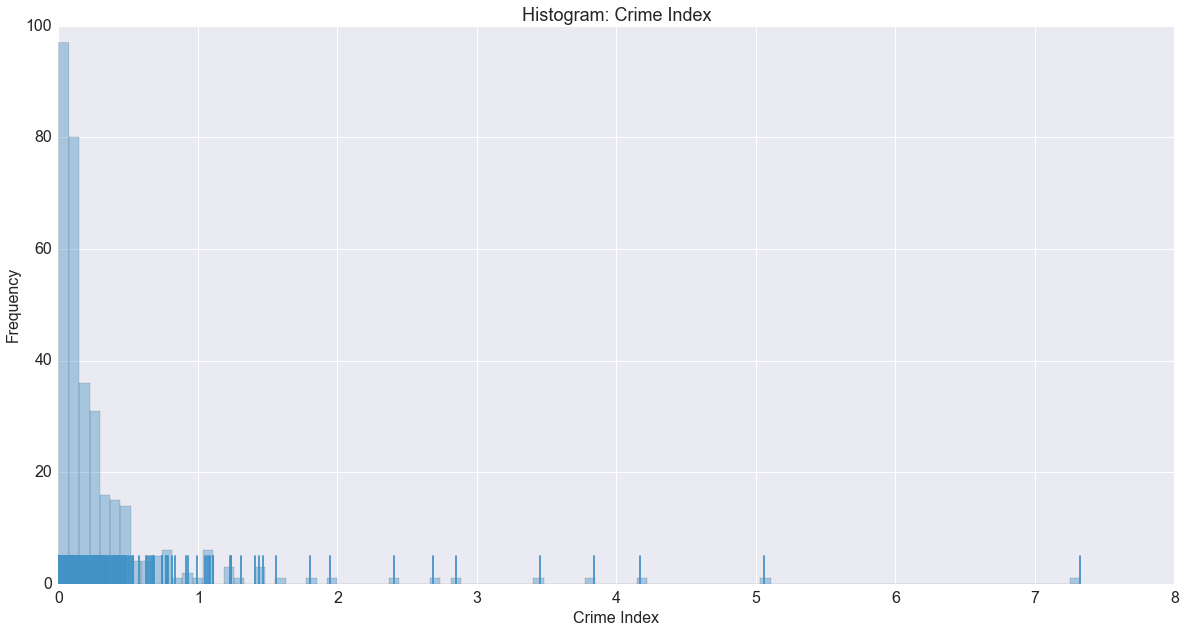

In [27]:
# Histogram: Crime Index
temp = data[['Crime_Index']] 

temp = temp[temp['Crime_Index'] < 10]
plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Crime Index', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Crime Index', fontsize = 18)

## Use log

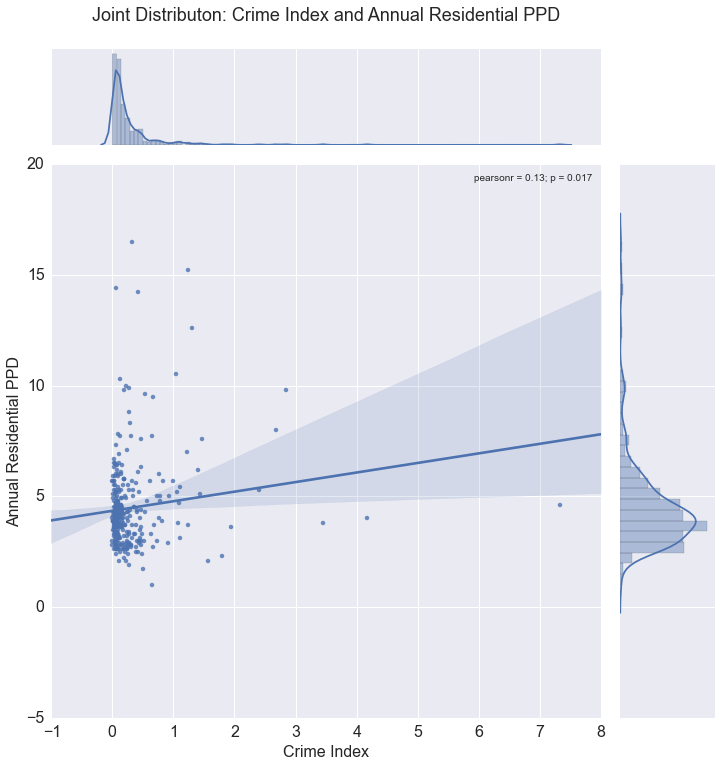

In [28]:
# Joint Distribution: Crime Index and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Crime_Index']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20) & (temp['Crime_Index'] < 10)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Crime_Index', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Crime Index', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Crime Index and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=red>Theil Index - Household Income</font>

- Modified calculations to use grouped population data as per income
- Theil index measures an entropic "distance" the population is away from the "ideal" egalitarian (believing in the principle that all people are equal and deserve equal rights and opportuinites) state of everyone having the same income.

$$T_T = \frac{1}{N} \sum_{i=1}^{N}\Big(\frac{x_i}{\bar{x}}\ln\frac{x_i}{\bar{x}}\Big)$$, where 
- $N$ is # of groups
- $i$ is particular individual *(group used in my calculation)*
- $x_i$ is income of $i^{th}$ individual *(group used in my calculation)*
- $\bar{x}$ is mean of $x_i$
- Normalized Theil Index = $T_T/ \ln N$ ranges from 0 to 1
- If everyone has same income, then $T_T$ = 0, i.e. Population's income has maximum disorder.
- If one person has all the income, then $T_T$ = $\ln N$, i.e. maximum order.

In [29]:
N = 10
c = data_cols[172:182]

data['HH_Theil_Index'] = ((data.ix[:,172]/data[c].mean(axis = 1) * np.log(data.ix[:,172]/data[c].mean(axis = 1))
                          + data.ix[:,173]/data[c].mean(axis = 1) * np.log(data.ix[:,173]/data[c].mean(axis = 1))
                          + data.ix[:,174]/data[c].mean(axis = 1) * np.log(data.ix[:,174]/data[c].mean(axis = 1))
                          + data.ix[:,175]/data[c].mean(axis = 1) * np.log(data.ix[:,175]/data[c].mean(axis = 1))
                          + data.ix[:,176]/data[c].mean(axis = 1) * np.log(data.ix[:,176]/data[c].mean(axis = 1))
                          + data.ix[:,177]/data[c].mean(axis = 1) * np.log(data.ix[:,177]/data[c].mean(axis = 1))
                          + data.ix[:,178]/data[c].mean(axis = 1) * np.log(data.ix[:,178]/data[c].mean(axis = 1)) 
                          + data.ix[:,179]/data[c].mean(axis = 1) * np.log(data.ix[:,179]/data[c].mean(axis = 1))
                          + data.ix[:,180]/data[c].mean(axis = 1) * np.log(data.ix[:,180]/data[c].mean(axis = 1))
                          + data.ix[:,181]/data[c].mean(axis = 1) * np.log(data.ix[:,181]/data[c].mean(axis = 1)))/N)

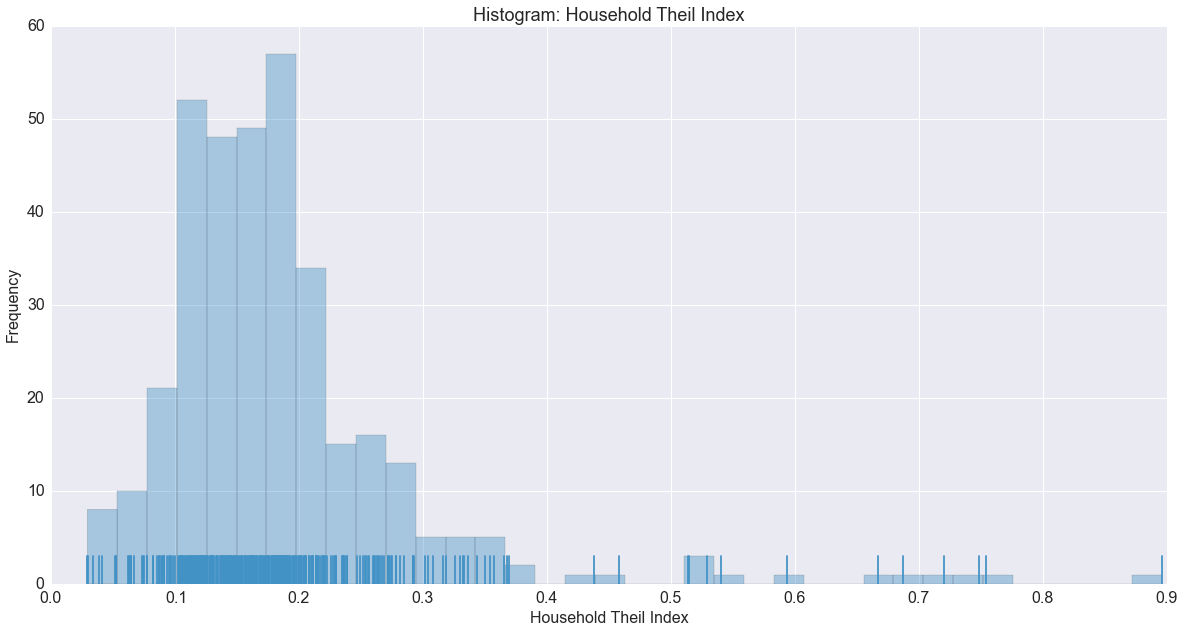

In [30]:
# Histogram: Household Theil Index
temp = data[['HH_Theil_Index']].dropna() # Drop NaN because of np.log(0) in Theil Index Calculation

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Household Theil Index', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Household Theil Index', fontsize = 18)

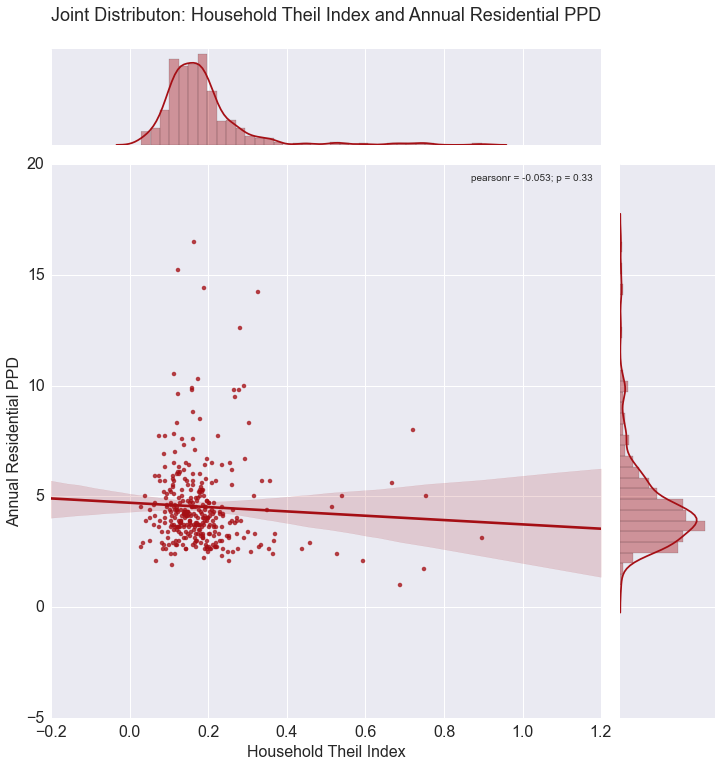

In [31]:
# Joint Distribution: Household Theil Index and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'HH_Theil_Index']].dropna()
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Drop NaN because of np.log(0) in Theil Index Calculation

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('HH_Theil_Index', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10, color = '#a50f15')
plt.xlabel('Household Theil Index', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Household Theil Index and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: If Res < 50 or 100 used, corr = -0.1, and if Res < 20 and HHIR < 10 used corr = -0.16 (without z-score also!)

## <font color=red>Mean Logarithmic Deviation</font> 

It is a measure of income inequality. MLD = 0 when everyone has the same income, and MLD takes on larger positive values as incomes become more unequal, especially at the high end.

$$MLD = \frac{1}{N}\sum_{i=1}^{N}\ln\frac{x_i}{\bar{x}}$$, where $N$ is the number of households, $x_i$ is the income of household $i$ and $\bar{x}$ is the mean of $x_i$

In [32]:
N = 10
c = data_cols[172:182]
data['HH_Income_MLD'] = (np.log(data.ix[:,172]/data[c].mean(axis = 1))
                          + np.log(data.ix[:,173]/data[c].mean(axis = 1))
                          + np.log(data.ix[:,174]/data[c].mean(axis = 1))
                          + np.log(data.ix[:,175]/data[c].mean(axis = 1))
                          + np.log(data.ix[:,176]/data[c].mean(axis = 1))
                          + np.log(data.ix[:,177]/data[c].mean(axis = 1))
                          + np.log(data.ix[:,178]/data[c].mean(axis = 1)) 
                          + np.log(data.ix[:,179]/data[c].mean(axis = 1))
                          + np.log(data.ix[:,180]/data[c].mean(axis = 1))
                          + np.log(data.ix[:,181]/data[c].mean(axis = 1)))/N

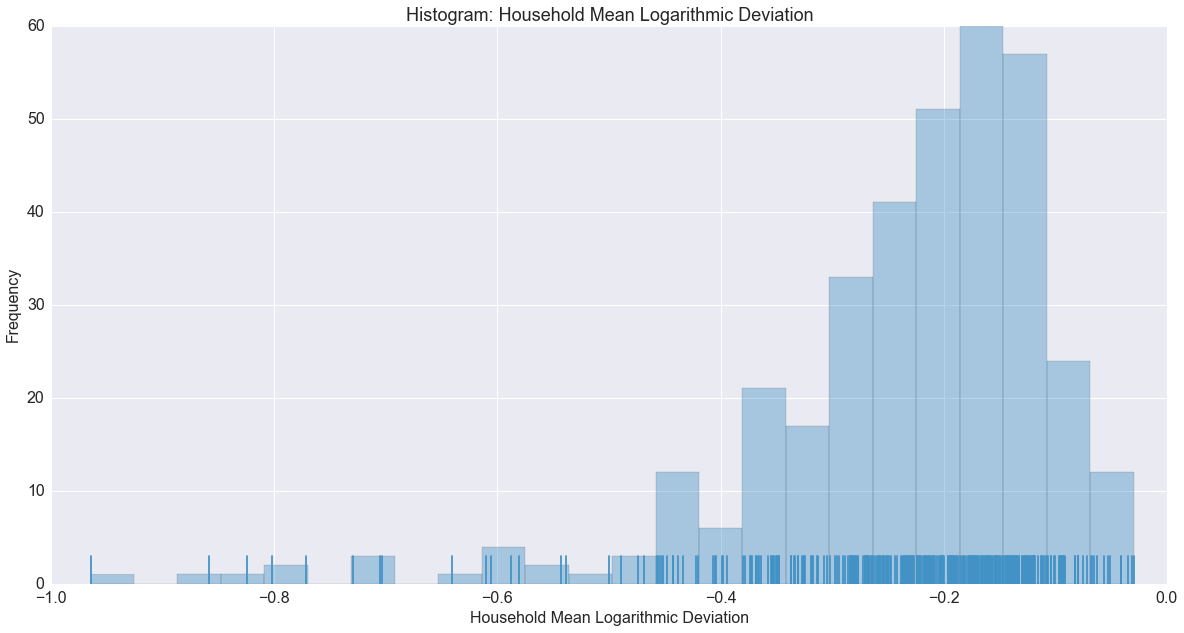

In [33]:
# Histogram: Household Mean Logarithmic Deviation
temp = data[['HH_Income_MLD']].dropna() # Drop NaN because of np.log(0) in MLD Calculation

temp = temp[temp['HH_Income_MLD'] > -100] # Take care of -infinity
plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Household Mean Logarithmic Deviation', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Household Mean Logarithmic Deviation', fontsize = 18)

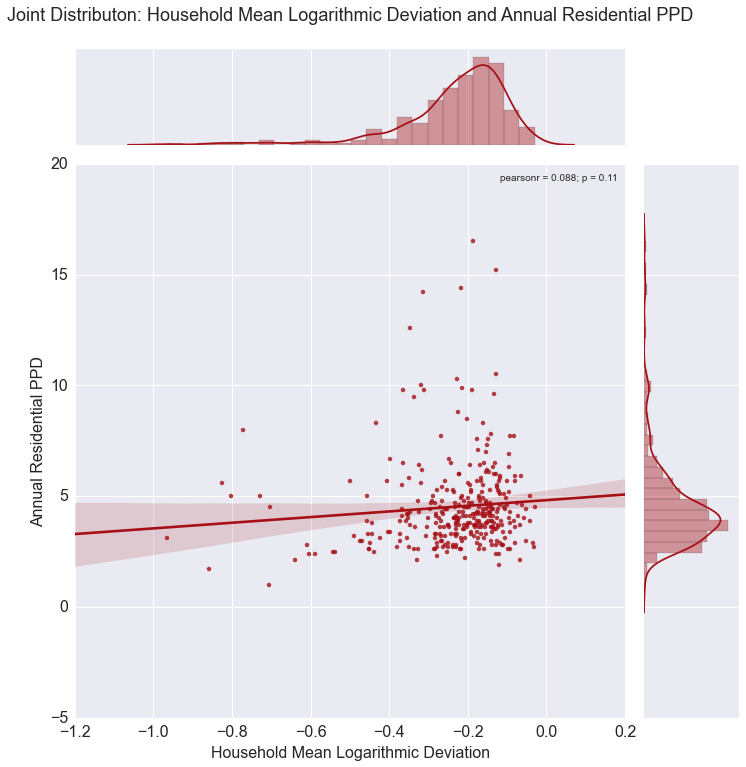

In [34]:
# Joint Distribution: Household Mean Logarithmic Deviation and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'HH_Income_MLD']].dropna()
temp = temp[(temp['Annual_ResPPD_2013'] < 20)& (temp['HH_Income_MLD'] > -100)] # Drop NaN because of np.log(0) in Theil Index Calculation

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('HH_Income_MLD', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10, color = '#a50f15')
plt.xlabel('Household Mean Logarithmic Deviation', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Household Mean Logarithmic Deviation and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=green>Household Income Ratio</font> 

- Household Income Ratio = $\frac{Population_{\leq\$25000}}{Population_{\geq\$75000}}$


In [35]:
data['HH_Income_Ratio'] = ((data[data_cols[172]] + data[data_cols[173]] + data[data_cols[174]])
                           / (data[data_cols[178]] + data[data_cols[179]] + data[data_cols[180]] + data[data_cols[181]]))

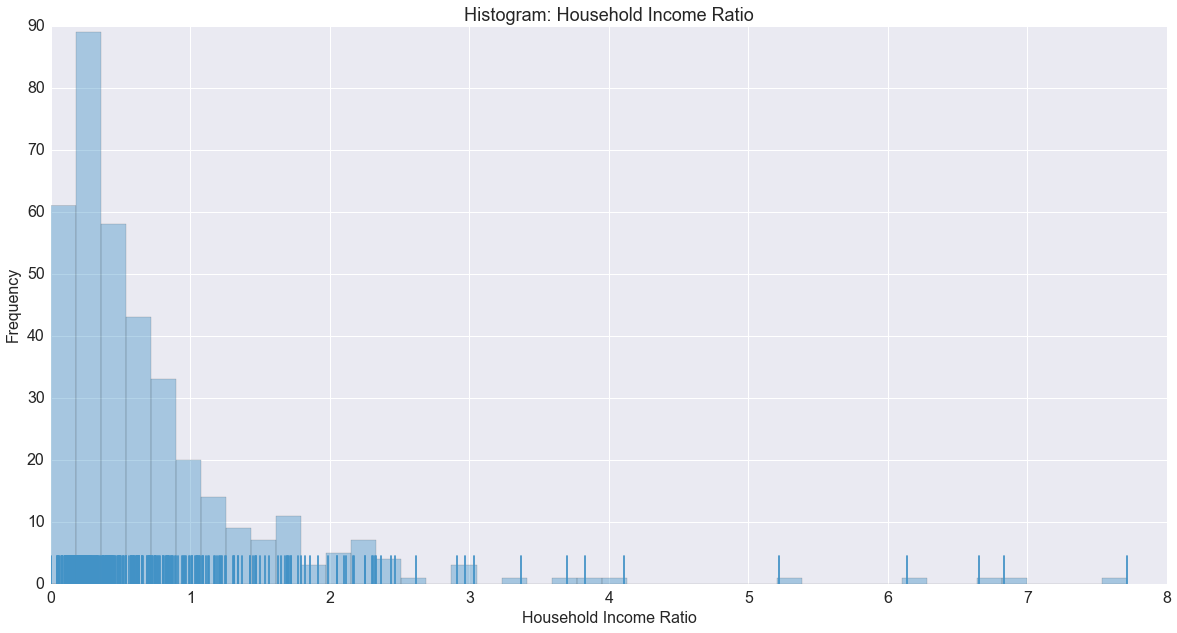

In [36]:
# Histogram: Household Income Ratio
temp = data[['HH_Income_Ratio']] 

temp = temp[temp['HH_Income_Ratio'] < 100] # Take care of infinity
plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Household Income Ratio', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Household Income Ratio', fontsize = 18)

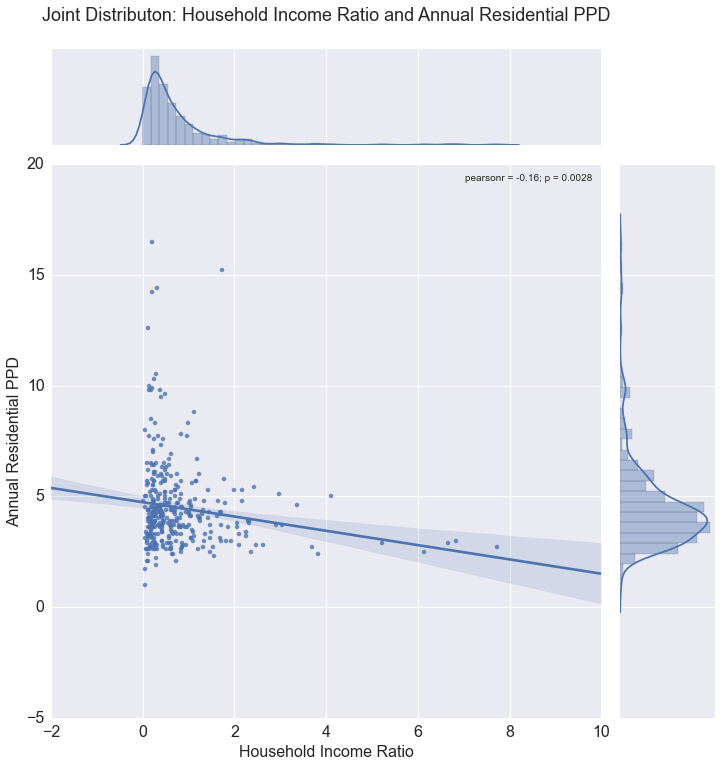

In [37]:
# Joint Distribution: Household Income Ratio and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'HH_Income_Ratio']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20) & (temp['HH_Income_Ratio'] < 100)] # Dropped outliers and infinity

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('HH_Income_Ratio', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Household Income Ratio', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Household Income Ratio and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: If Res < 50 or 100 used, corr = -0.1, and if Res < 20 and HHIR < 10 used corr = -0.16 (without z-score also!)

## <font color=green>Family Income Ratio</font> 

- Family Income Ratio = $\frac{Population_{\leq\$25000}}{Population_{\geq\$75000}}$

In [38]:
data['Fam_Income_Ratio'] = ((data[data_cols[193]] + data[data_cols[194]] + data[data_cols[195]])
                           / (data[data_cols[199]] + data[data_cols[200]] + data[data_cols[201]] + data[data_cols[202]]))

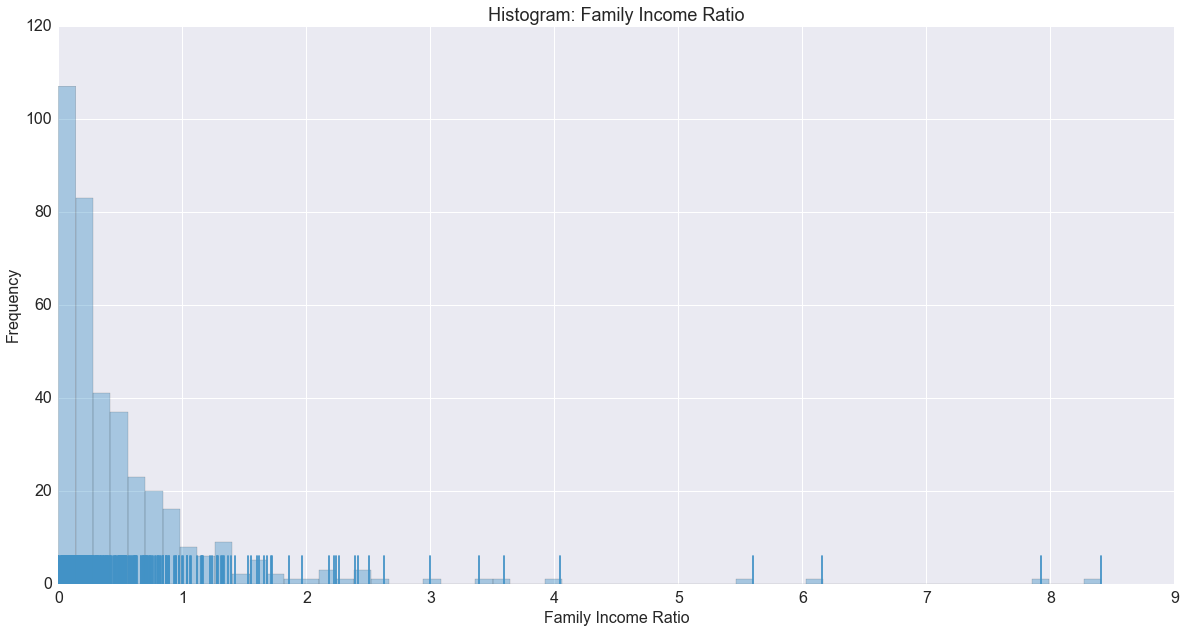

In [39]:
# Histogram: Family Income Ratio
temp = data[['Fam_Income_Ratio']] 

temp = temp[temp['Fam_Income_Ratio'] < 100] # Take care of infinity
plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Family Income Ratio', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Family Income Ratio', fontsize = 18)

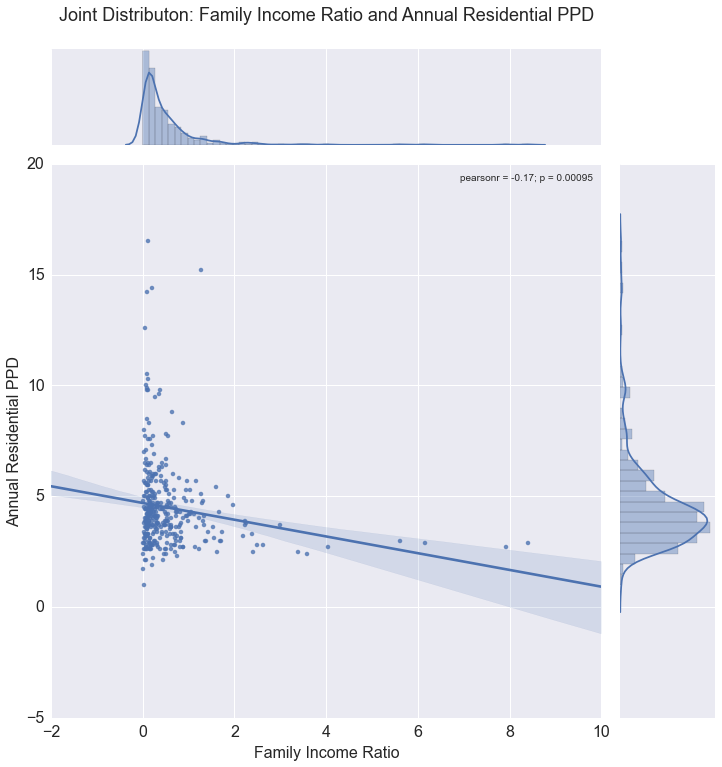

In [40]:
# Joint Distribution: Family Income Ratio and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Fam_Income_Ratio']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20) & (temp['Fam_Income_Ratio'] < 100)] # Dropped outliers and infinity

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Fam_Income_Ratio', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Family Income Ratio', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Family Income Ratio and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Note: If Res < 50 or 100 used, corr = -0.1, and if Res < 20 and FIR < 10 used corr = -0.17(without z-score also!)

## <font color=red>No Health Insurance to Health Insurance Ratio</font>

In [41]:
data['NoInsurance_Insurance_Ratio'] = data[data_cols[210]]/data[data_cols[207]]

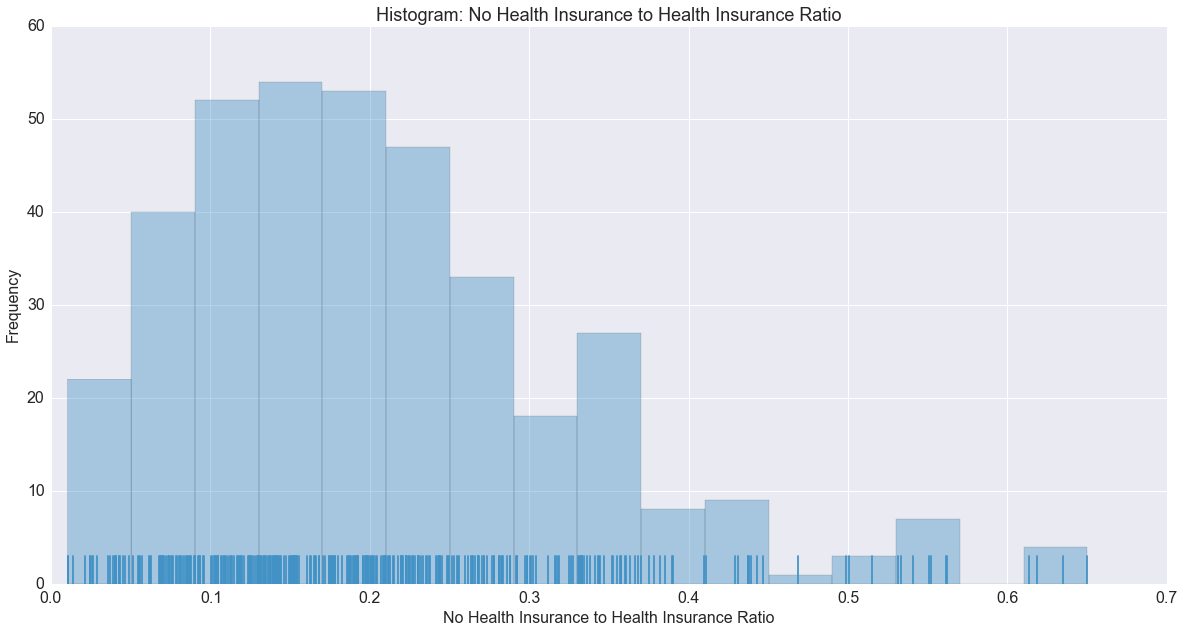

In [42]:
# Histogram: No Health Insurance to Health Insurance Ratio
temp = data[['NoInsurance_Insurance_Ratio']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('No Health Insurance to Health Insurance Ratio', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: No Health Insurance to Health Insurance Ratio', fontsize = 18)

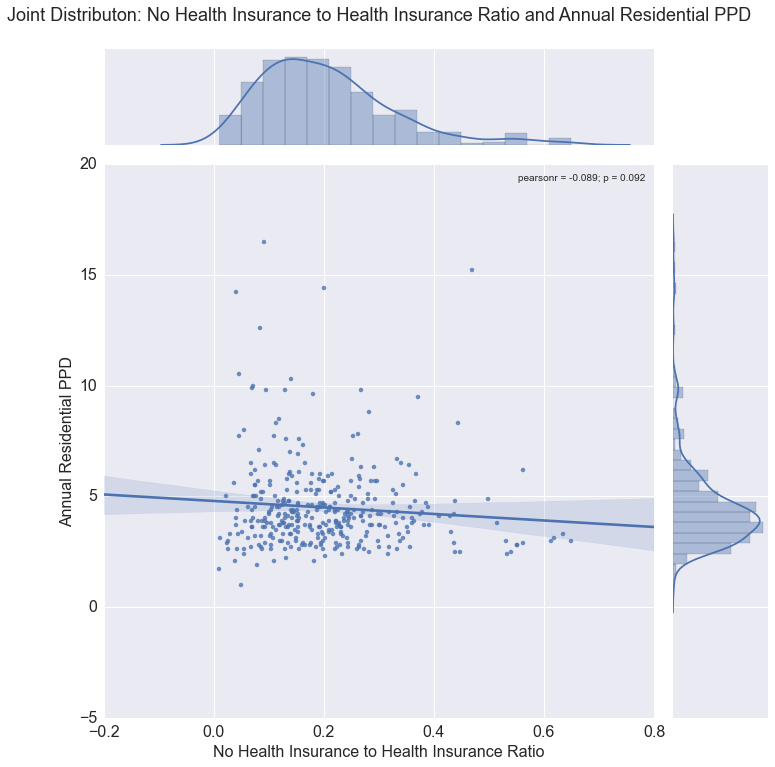

In [43]:
# Joint Distribution: No Health Insurance to Health Insurance Ratio and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'NoInsurance_Insurance_Ratio']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('NoInsurance_Insurance_Ratio', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('No Health Insurance to Health Insurance Ratio', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: No Health Insurance to Health Insurance Ratio and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=red>Private Health Insurance to Public Health Insurance Ratio</font>

In [44]:
data['PrivateHI_PublicHI_Ratio'] = data[data_cols[208]]/data[data_cols[209]]

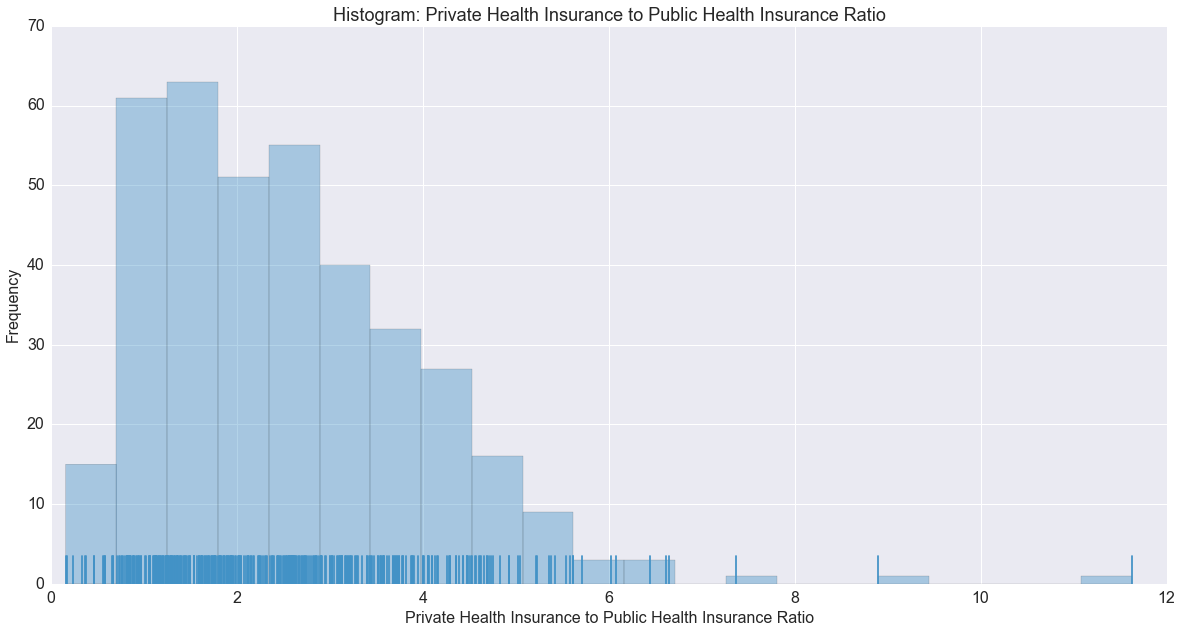

In [45]:
# Histogram: Private Health Insurance to Public Health Insurance Ratio
temp = data[['PrivateHI_PublicHI_Ratio']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Private Health Insurance to Public Health Insurance Ratio', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Private Health Insurance to Public Health Insurance Ratio', fontsize = 18)

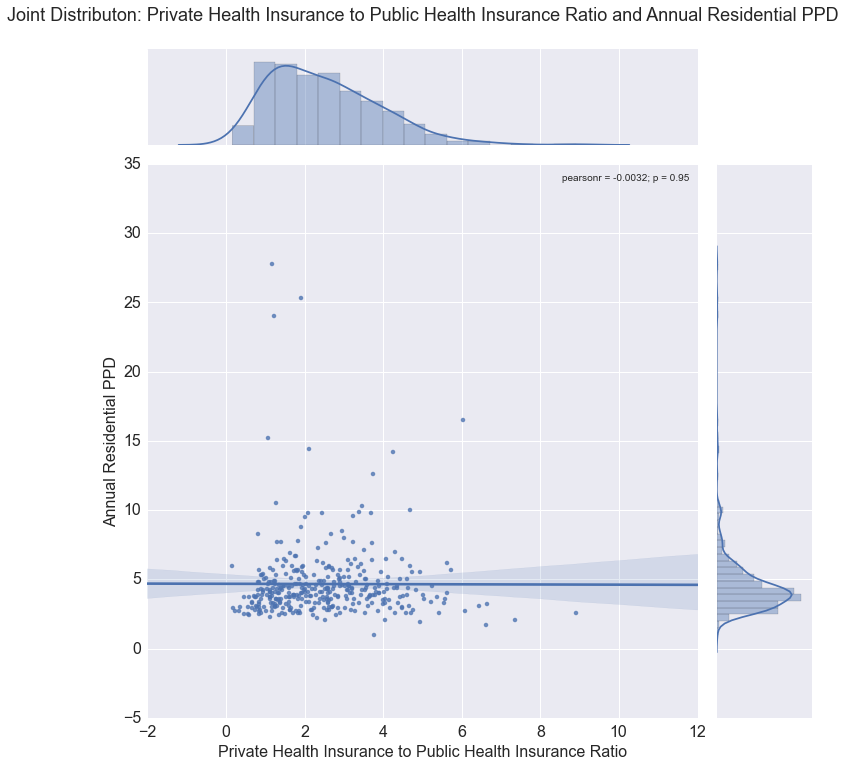

In [46]:
# Joint Distribution: Private Health Insurance to Public Health Insurance Ratio and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'PrivateHI_PublicHI_Ratio']]
temp = temp[(temp['Annual_ResPPD_2013'] < 100)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('PrivateHI_PublicHI_Ratio', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Private Health Insurance to Public Health Insurance Ratio', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Private Health Insurance to Public Health Insurance Ratio and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=green>Income Index</font>

$$Income \; Index = \frac{\ln (x) - \ln (Income_{min})}{\ln (Income_{max}) - \ln (Income_{min})}$$

Then take Geometric Mean of Income Indices:

$$Geometric \; Mean = \Big(\prod_i^N x_i\Big)^{\frac{1}{N}}$$

---
- Mean Household Income - 183
- Mean Earnings - 185
- Mean Social Security Income - 187
- Mean Family Income - 356
- Mean Non-family Household Income - 347
- Mean Supplemental Security Income - 361
- Mean Retirement Income - 370
- Mean Public Assistance Income - 371

In [47]:
# List of new Income columns
inc_name = ['i-1', 'i-2', 'i-3', 'i-4', 'i-5', 'i-6', 'i-7', 'i-8']

# List of original Income column ID's
inc_cols = [183, 185, 187, 356, 347, 361, 370, 371]

# Create new Income columns in dataframe
for i, col in enumerate(inc_name):
    data[col] = data[[inc_cols[i]]]
    
# Max and Min Income overall
inc_max = 250000 # California's Highest Median HH/Family Income #162000
inc_min = 2500 # California's Lowest Median HH/Family Income #3500

# Apply Income Index calculation formula
for col in inc_name:
    data[col] = data[col].apply(lambda x: (np.log(x) - np.log(inc_min))/(np.log(inc_max) - np.log(inc_min)))
    
# Geometric Mean of Income Index Calculation
data['gMean_Income_Index'] = (data['i-1'] * data['i-2'] * data['i-3'] * data['i-4'] * data['i-5'] 
                              * data['i-6'] * data['i-7'] * data['i-8']) ** (1.0/len(inc_name))

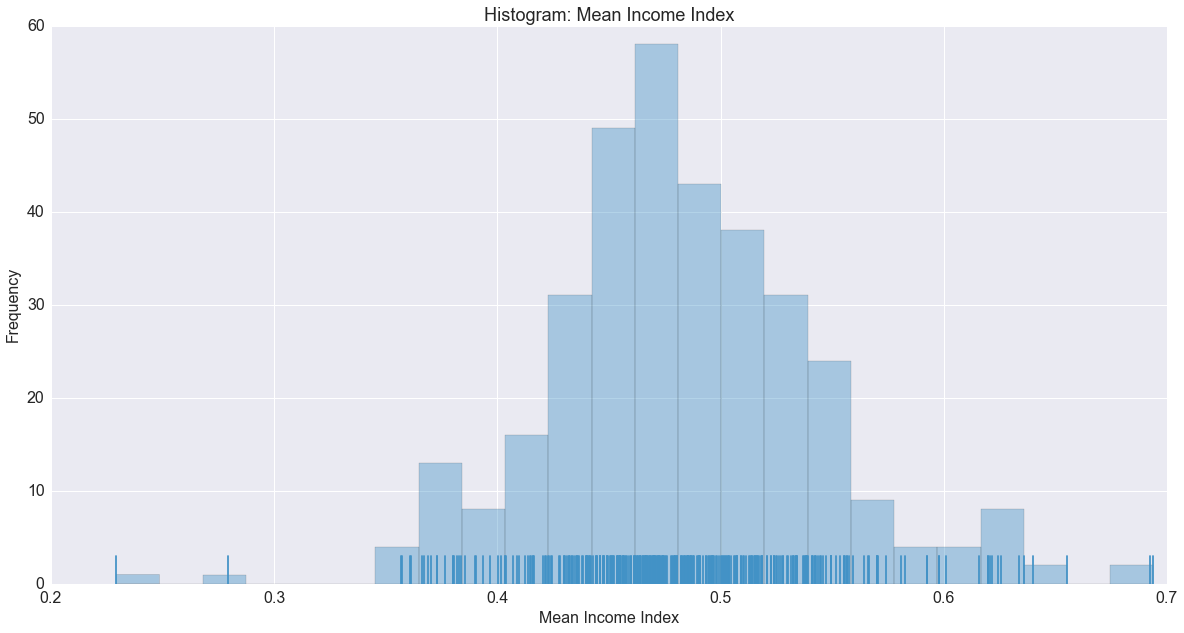

In [48]:
# Histogram: Mean Income Index
temp = data[['gMean_Income_Index']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Mean Income Index', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Mean Income Index', fontsize = 18)

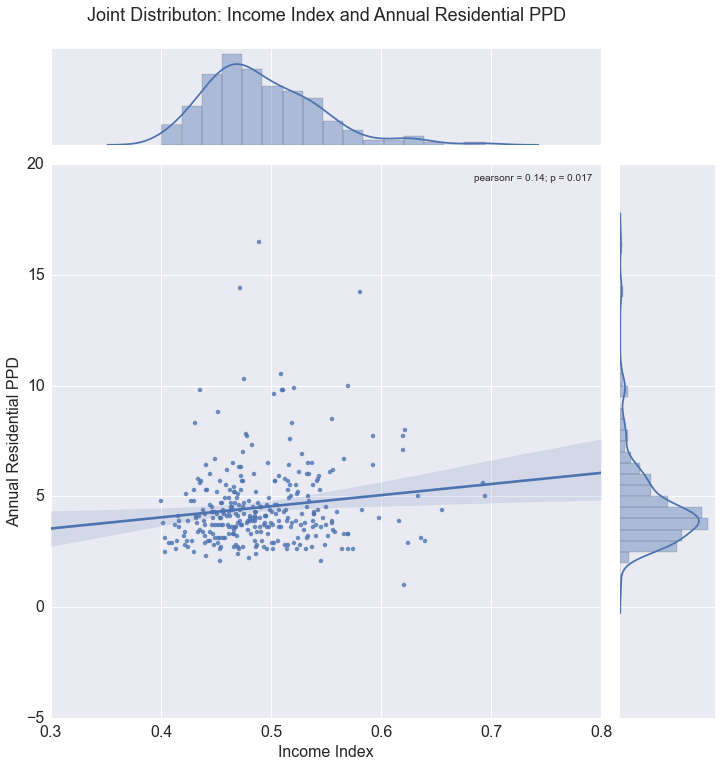

In [49]:
# Joint Distribution: Income Index and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'gMean_Income_Index']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20) & (temp['gMean_Income_Index'] > 0.4)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('gMean_Income_Index', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Income Index', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Income Index and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Removing Res and Income Index outliers gives better corr

## <font color=green>Per Capita Income Index</font>

In [50]:
# Max and Min Per Capita Income
pcinc_max = 162000 # California's Highest Per Capita Income 
pcinc_min = 3500 # California's Lowest Per Capita Income 

data['PerCapitaIncome_Index'] = data[[data_cols[203]]].apply(lambda x: (np.log(x) - np.log(pcinc_min))/(np.log(pcinc_max) - np.log(pcinc_min)), axis = 1)

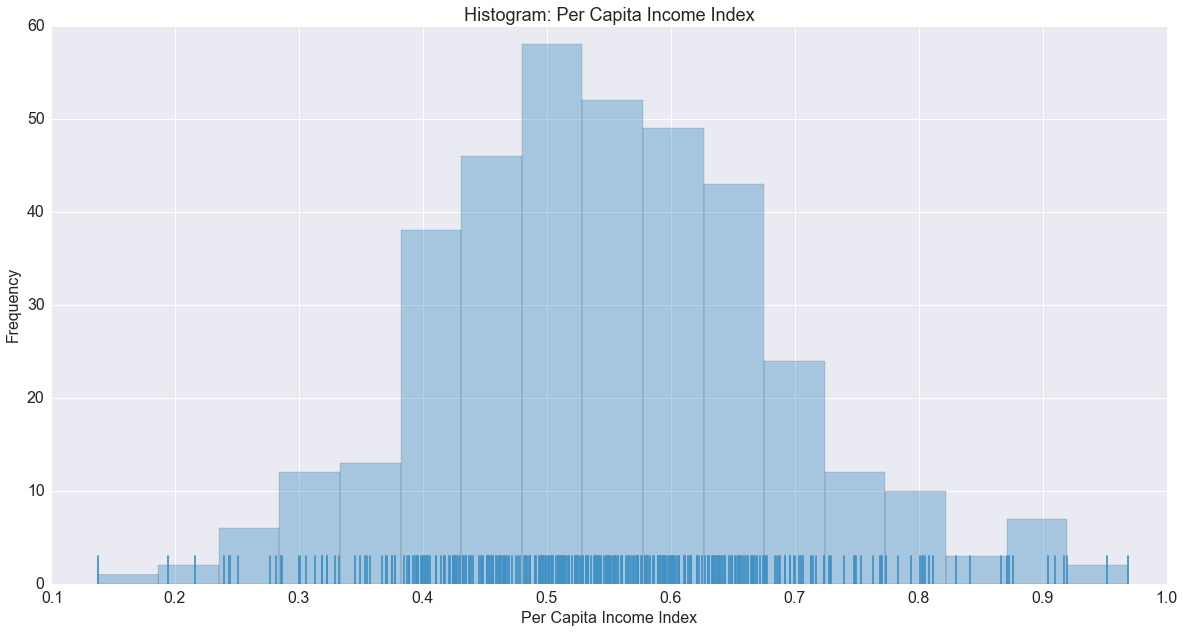

In [51]:
# Histogram: Per Capita Income Index
temp = data[['PerCapitaIncome_Index']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Per Capita Income Index', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Per Capita Income Index', fontsize = 18)

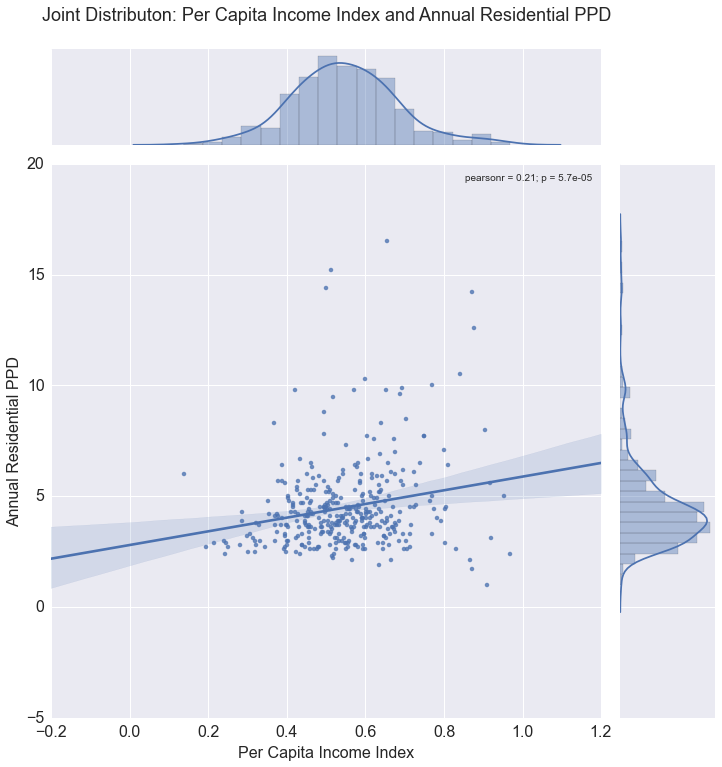

In [52]:
# Joint Distribution: Per Capita Income Index and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'PerCapitaIncome_Index']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('PerCapitaIncome_Index', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Per Capita Income Index', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Per Capita Income Index and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Removing Res outliers gives better corr

## <font color=green>Travel Time Index</font>

$$Travel \; Time \; Index = \frac{\ln (t) - \ln (t_{min})}{\ln (t_{max}) - \ln (t_{min})}$$


In [53]:
# Min Mean Travel Time
time_min = 9

# Max Mean Travel Time
time_max = 50

# Travel Time Index
data['Travel_Time_Index'] = data[[data_cols[351]]].apply(lambda x: (np.log(x) - np.log(time_min))/(np.log(time_max) - np.log(time_min)), axis = 1)

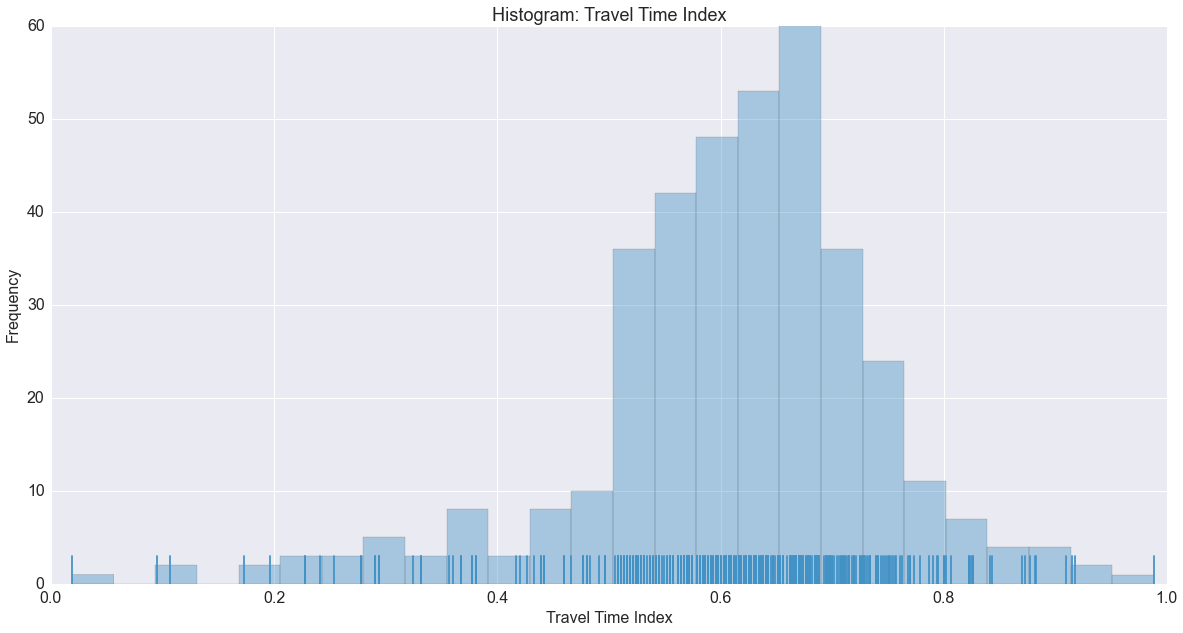

In [54]:
# Histogram: Travel Time Index
temp = data[['Travel_Time_Index']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Travel Time Index', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Travel Time Index', fontsize = 18)

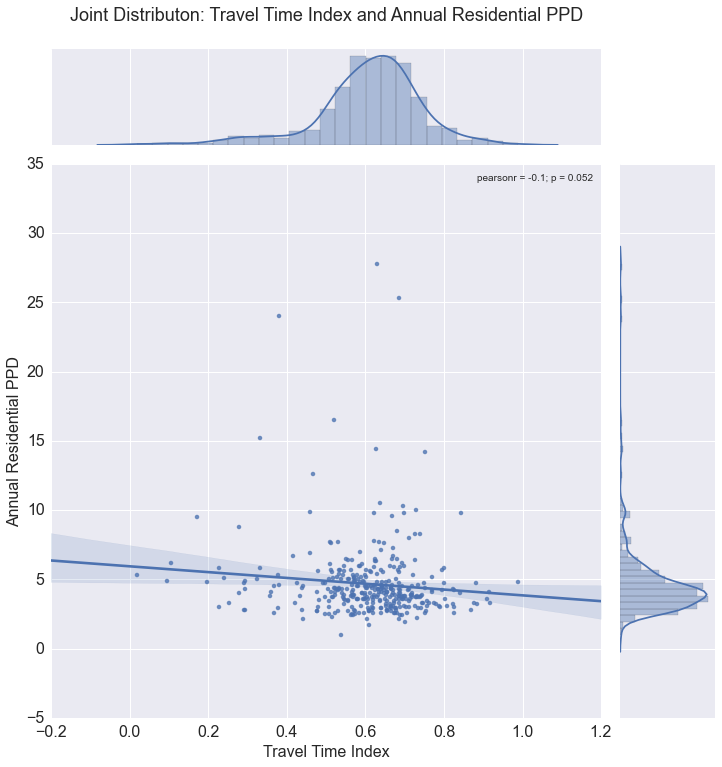

In [55]:
# Joint Distribution: Travel Time Index and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Travel_Time_Index']]
temp = temp[(temp['Annual_ResPPD_2013'] < 100)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Travel_Time_Index', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Travel Time Index', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Travel Time Index and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Removing Res outliers gives better corr

## <font color=green>Median Income Index</font>

In [56]:
# List of new Income columns
inc_name = ['mi-1', 'mi-2', 'mi-3']

# List of original Income column ID's
inc_cols = [182, 352, 368]

# Create new Income columns in dataframe
for i, col in enumerate(inc_name):
    data[col] = data[[inc_cols[i]]]
    
# Max and Min Income
inc_max = 250000 # California's Highest Median HH/Family Income #162000
inc_min = 2500 # California's Lowest Median HH/Family Income #3500

# Apply Income Index calculation formula
for col in inc_name:
    data[col] = data[col].apply(lambda x: (np.log(x) - np.log(inc_min))/(np.log(inc_max) - np.log(inc_min)))
    
# Geometric Mean of Income Index Calculation
data['gMedian_Income_Index'] = (data['mi-1'] * data['mi-2'] * data['mi-3']) ** (1.0/len(inc_name))

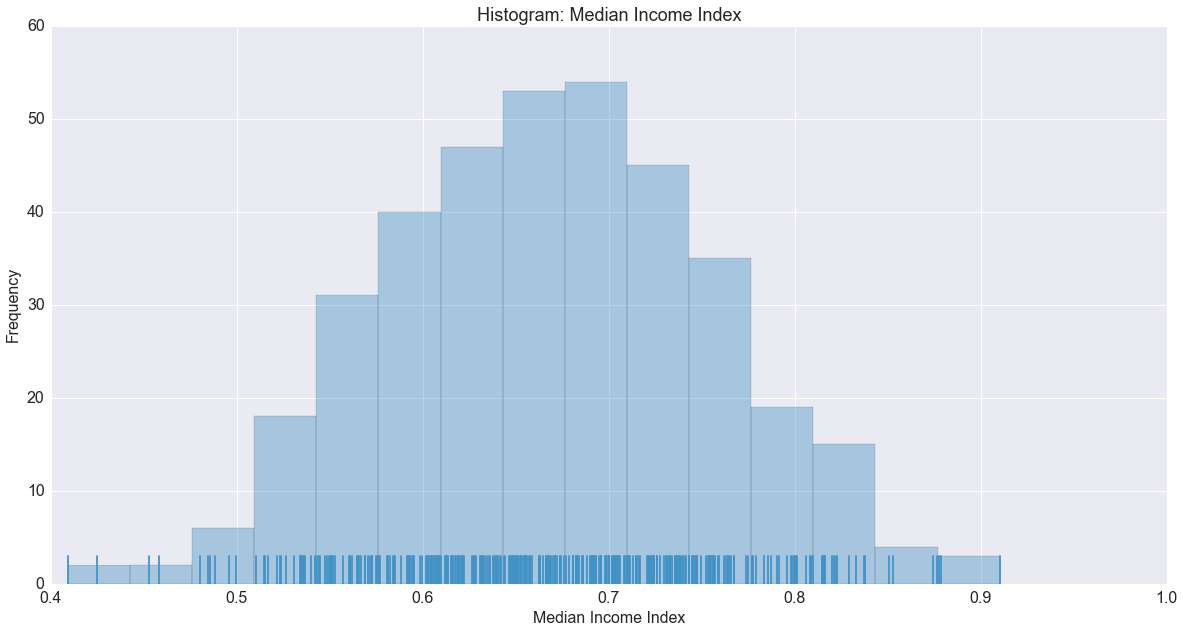

In [57]:
# Histogram: Median Income Index
temp = data[['gMedian_Income_Index']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Median Income Index', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Median Income Index', fontsize = 18)

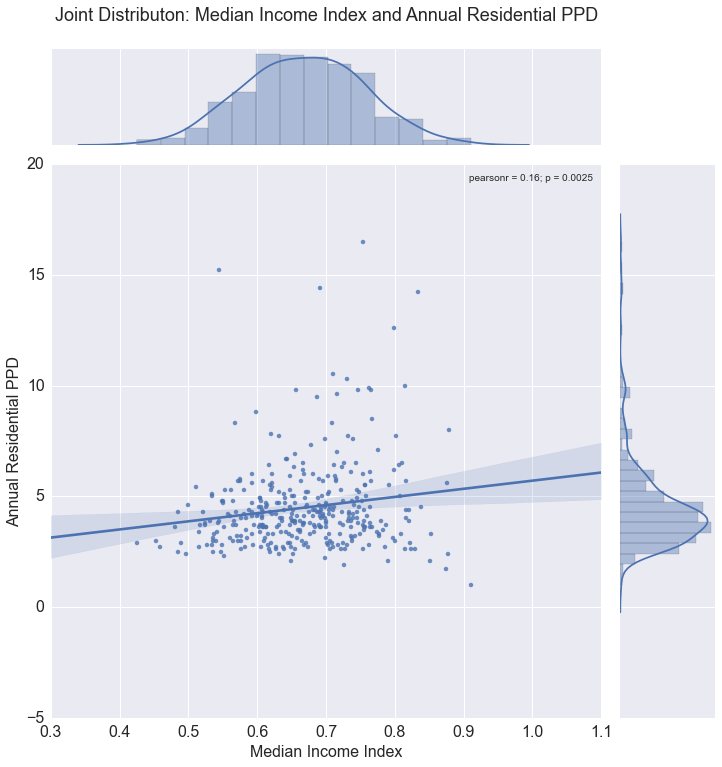

In [58]:
# Joint Distribution: Median Income Index and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'gMedian_Income_Index']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('gMedian_Income_Index', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Median Income Index', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Median Income Index and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Removing Res outliers gives better corr

## <font color=red>Female Median Earning to Male Median Earning Ratio</font>

In [59]:
data['Female_Male_Earning_Ratio'] = data[data_cols[365]]/data[data_cols[354]]

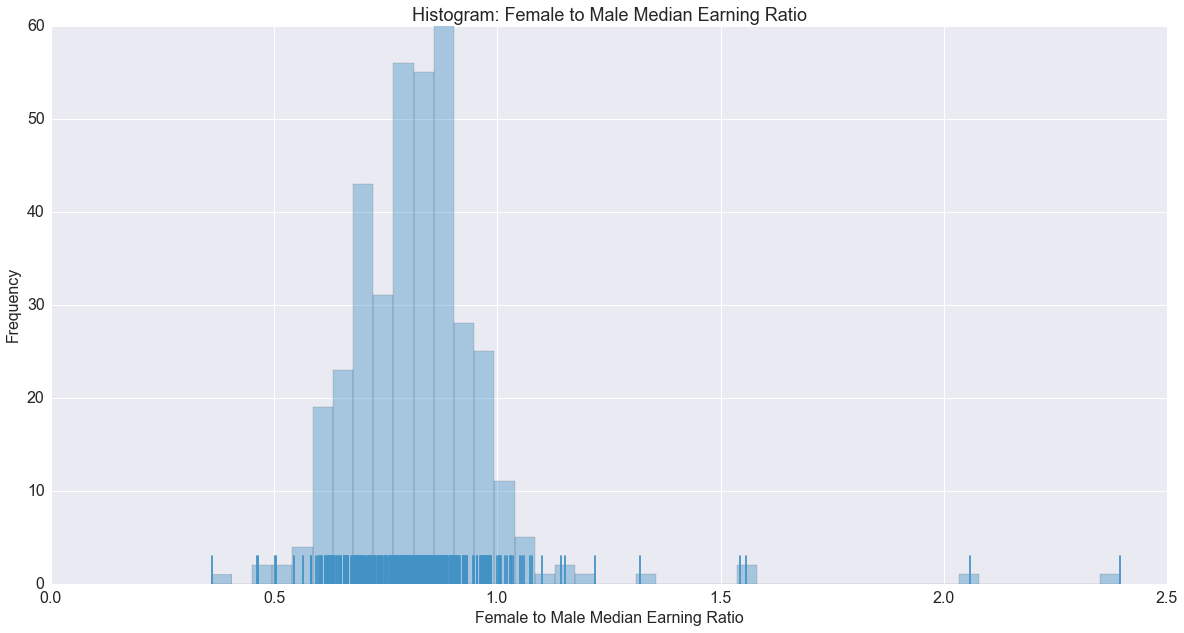

In [60]:
# Histogram: Female to Male Median Earning Ratio
temp = data[['Female_Male_Earning_Ratio']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Female to Male Median Earning Ratio', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Female to Male Median Earning Ratio', fontsize = 18)

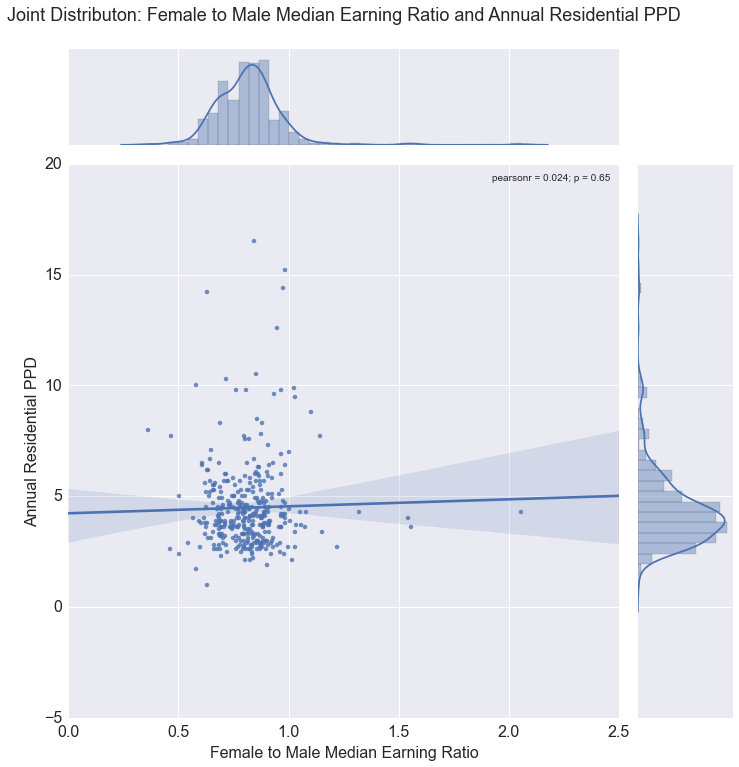

In [61]:
# Joint Distribution: Female to Male Median Earning Ratio and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Female_Male_Earning_Ratio']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Female_Male_Earning_Ratio', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Female to Male Median Earning Ratio', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Female to Male Median Earning Ratio and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

# Removing Res outliers gives better corr

## <font color=green>Male Female Median Income Earning Index</font>

In [62]:
# List of new Income columns
inc_name = ['i-1', 'i-2']

# List of original Income column ID's
inc_cols = [354, 365]

# Create new Income columns in dataframe
for i, col in enumerate(inc_name):
    data[col] = data[[inc_cols[i]]]
    
# Max and Min Income overall
inc_max = 250000 # California's Highest Median HH/Family Income 
inc_min = 2500 # California's Lowest Median HH/Family Income 

# Apply Income Index calculation formula
for col in inc_name:
    data[col] = data[col].apply(lambda x: (np.log(x) - np.log(inc_min))/(np.log(inc_max) - np.log(inc_min)))
    
# Geometric Mean of Income Index Calculation
data['MF_MedianEarnings_Index'] = (data['i-1'] * data['i-2']) ** (1.0/len(inc_name))

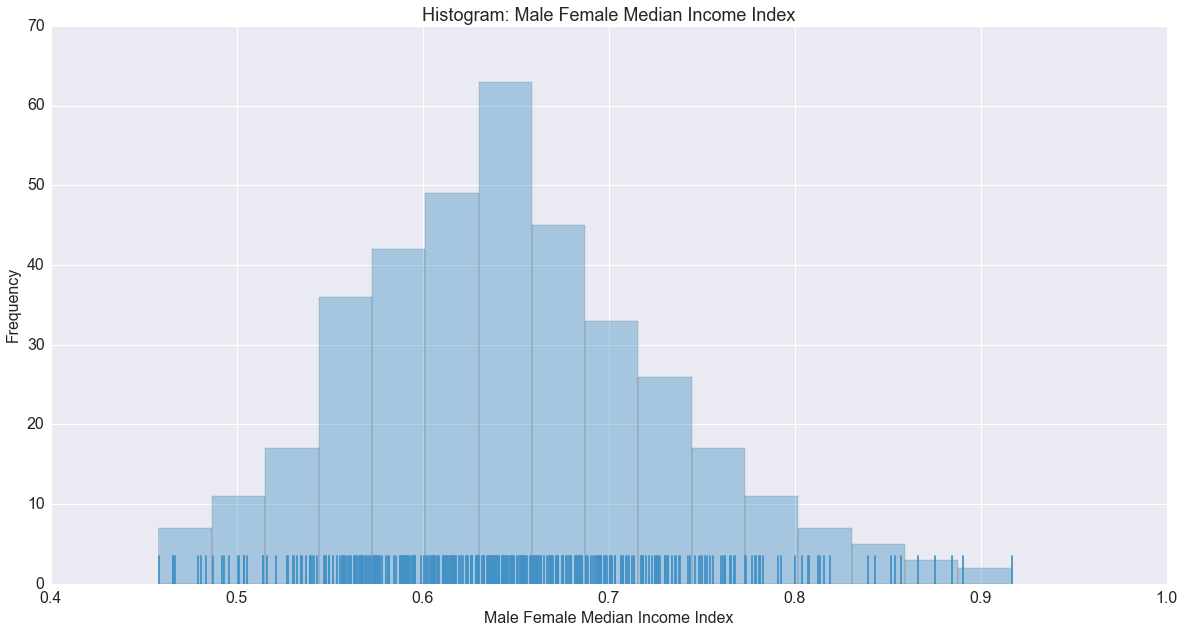

In [63]:
# Histogram: Male Female Median Income Index
temp = data[['MF_MedianEarnings_Index']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Male Female Median Income Index', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Male Female Median Income Index', fontsize = 18)

# Removing Res outliers gives better corr

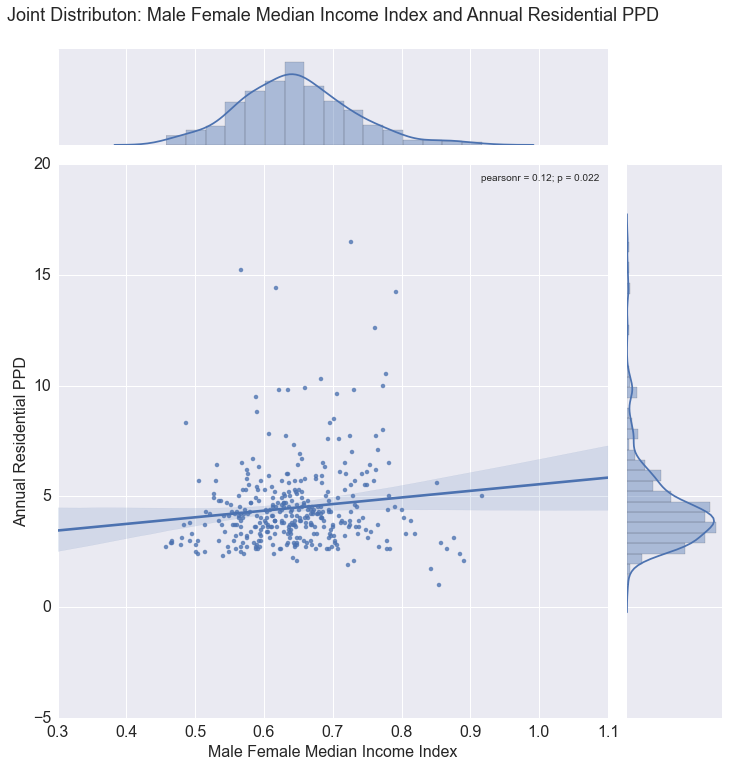

In [64]:
# Joint Distribution: Male Female Median Income Index and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'MF_MedianEarnings_Index']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('MF_MedianEarnings_Index', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Male Female Median Income Index', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Male Female Median Income Index and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=green>Residential Solar Units/Person</font>

In [65]:
data['Solar_ResUnits/Person'] = data['SolarUnits_Residential']/data['Population']

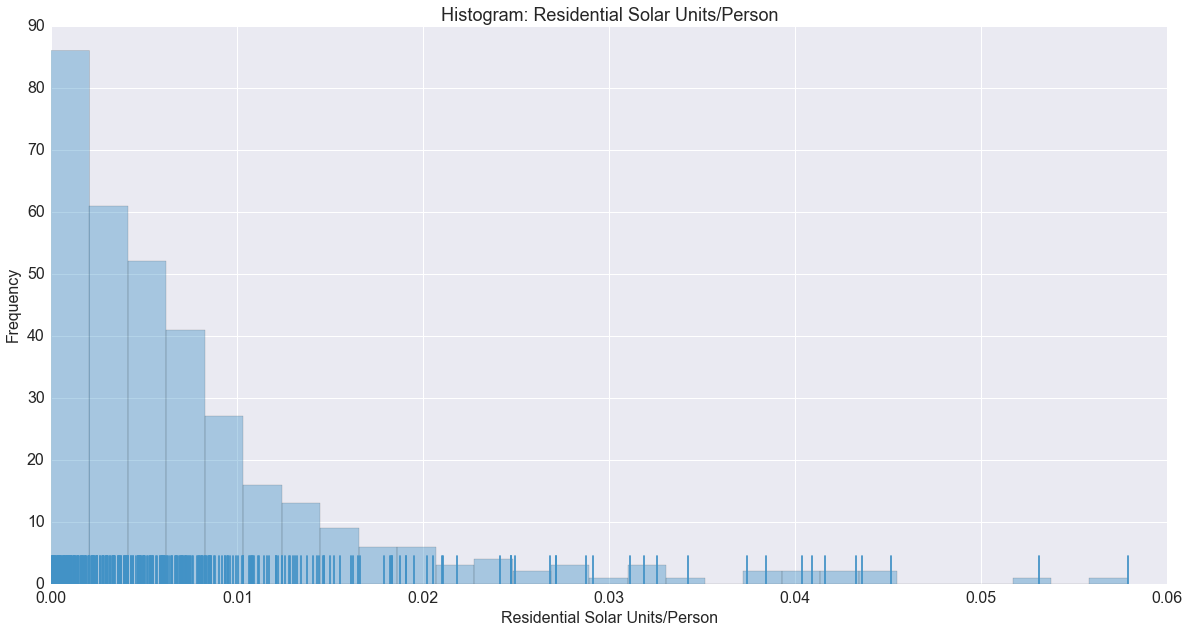

In [66]:
# Histogram: Residential Solar Units/Person
temp = data[['Solar_ResUnits/Person']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Residential Solar Units/Person', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Residential Solar Units/Person', fontsize = 18)

In [67]:
## Transformations: Check Tukey's ladder of transformations - http://onlinestatbook.com/2/transformations/transformations.pdf
#box_cox = sp.stats.boxcox(data['Solar_ResUnits/Person'], lmbda=None, alpha=None)
sp.stats.boxcox_normmax(data['Solar_ResUnits/Person'], brack=(-2.0, 2.0), method='pearsonr')

8.4721358117221772

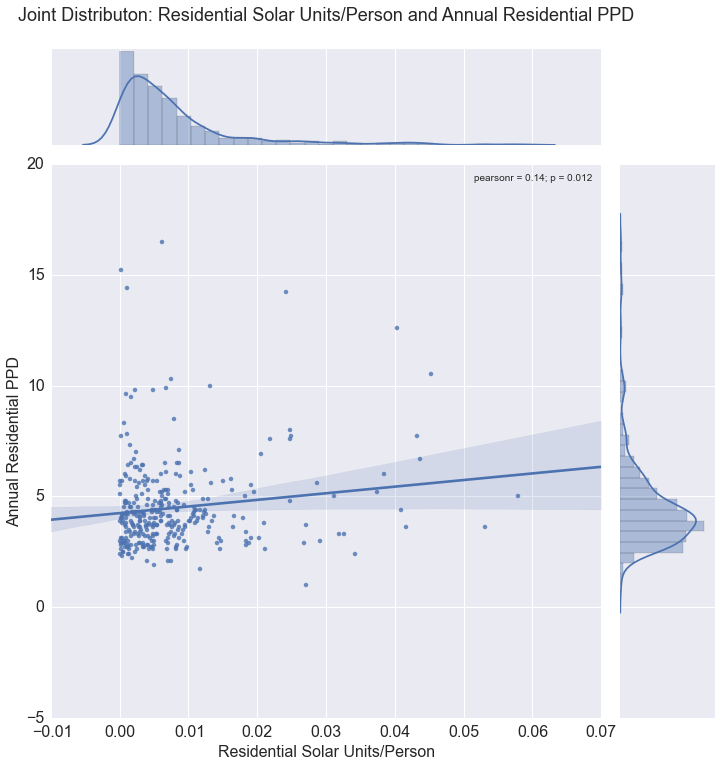

In [68]:
# Joint Distribution: Residential Solar Units/Person and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Solar_ResUnits/Person']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)
sns.jointplot('Solar_ResUnits/Person', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Residential Solar Units/Person', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Residential Solar Units/Person and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=green>Residential Solar Units/Household</font>

In [69]:
data['Solar_ResUnits/HH'] = data['SolarUnits_Residential']/data['TotalHH']

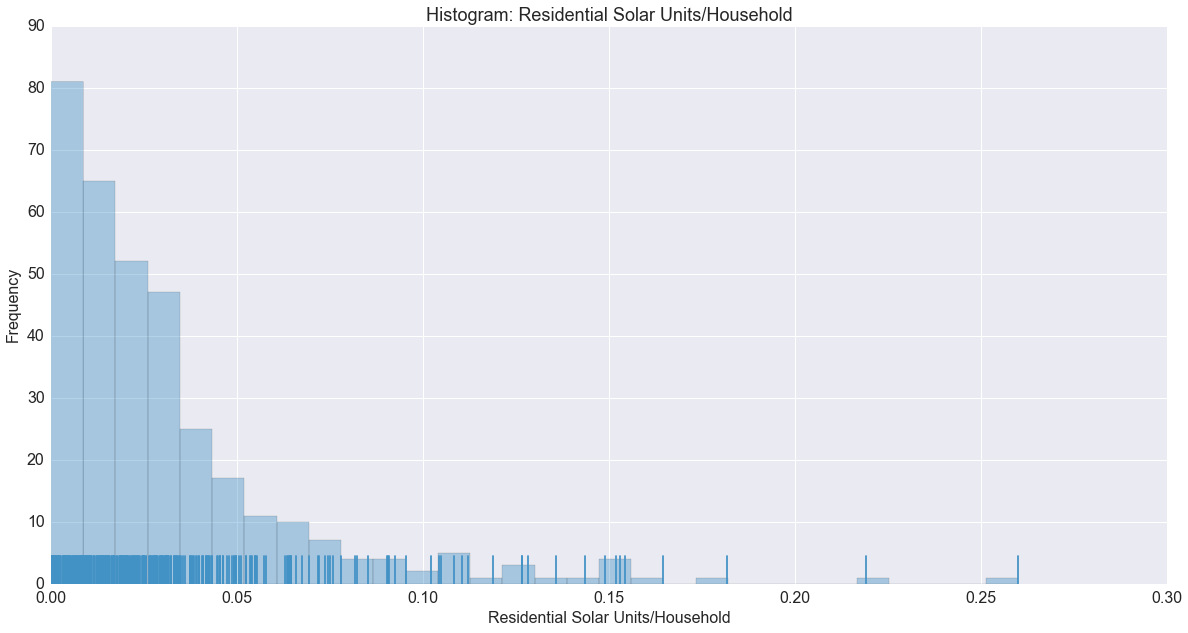

In [70]:
# Histogram: Residential Solar Units/Household
temp = data[['Solar_ResUnits/HH']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Residential Solar Units/Household', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Residential Solar Units/Household', fontsize = 18)

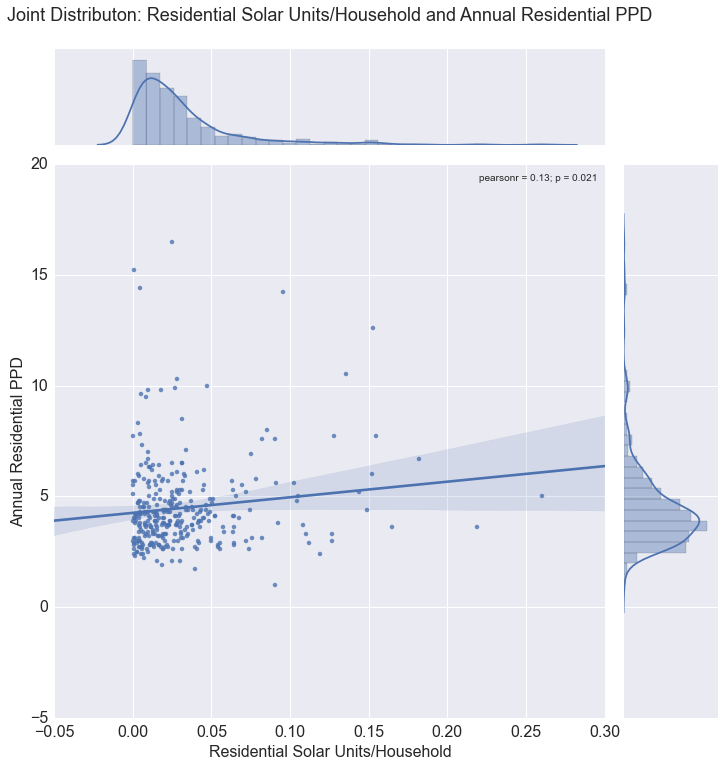

In [71]:
# Joint Distribution: Residential Solar Units/Household and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Solar_ResUnits/HH']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)
sns.jointplot('Solar_ResUnits/HH', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Residential Solar Units/Household', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Residential Solar Units/Household and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=red>Commercial Solar Units to Residential Solar Units Ratio</font>

In [72]:
data['Com_Res_Solar_Ratio'] = data['SolarUnits_Commercial']/data['SolarUnits_Residential']

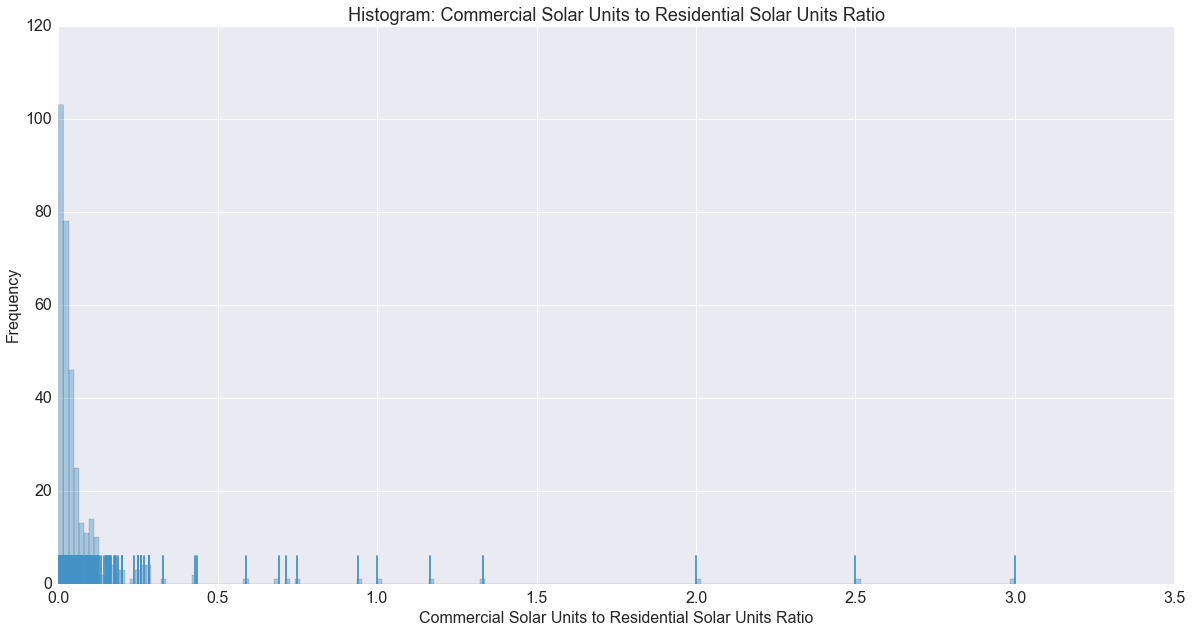

In [73]:
# Histogram: Commercial Solar Units to Residential Solar Units Ratio
temp = data[['Com_Res_Solar_Ratio']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Commercial Solar Units to Residential Solar Units Ratio', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Commercial Solar Units to Residential Solar Units Ratio', fontsize = 18)

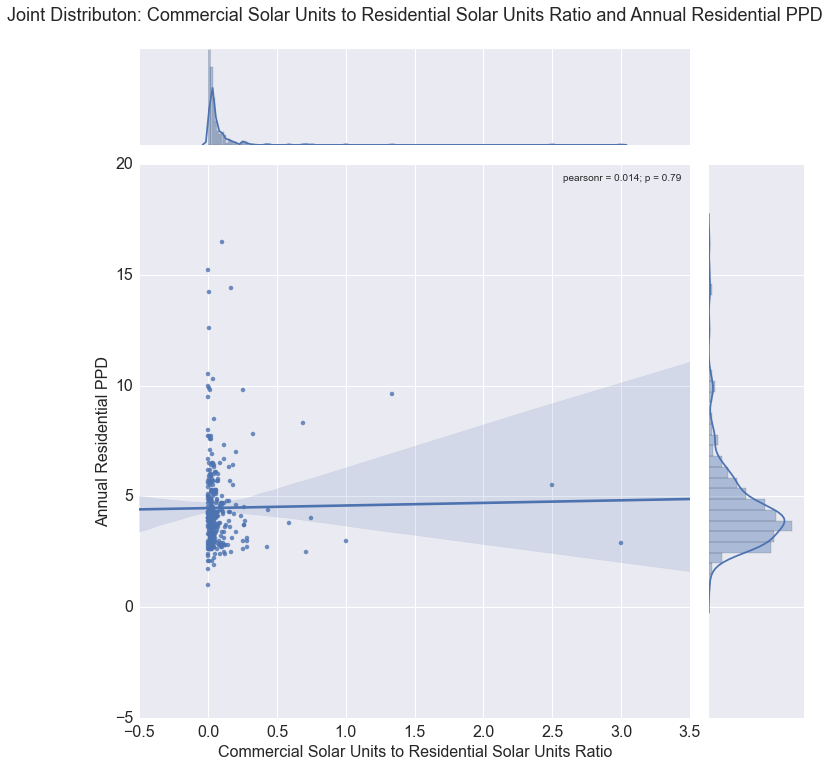

In [74]:
# Joint Distribution: Commercial Solar Units to Residential Solar Units Ratio and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Com_Res_Solar_Ratio']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)
sns.jointplot('Com_Res_Solar_Ratio', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Commercial Solar Units to Residential Solar Units Ratio', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Commercial Solar Units to Residential Solar Units Ratio and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=red>Building Permits Issued/Square Mile</font>

In [75]:
data['Permits/Area'] = data['Total_2013']/data['Area_SqMi']

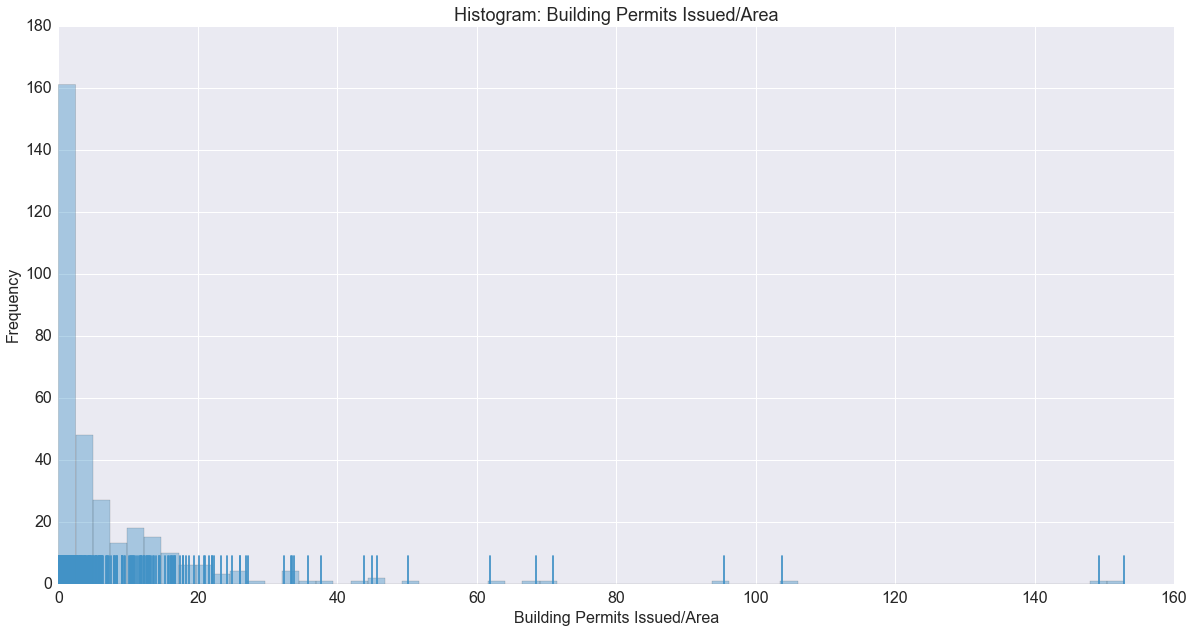

In [76]:
# Histogram: Building Permits Issued/Area
temp = data[['Permits/Area']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Building Permits Issued/Area', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Building Permits Issued/Area', fontsize = 18)

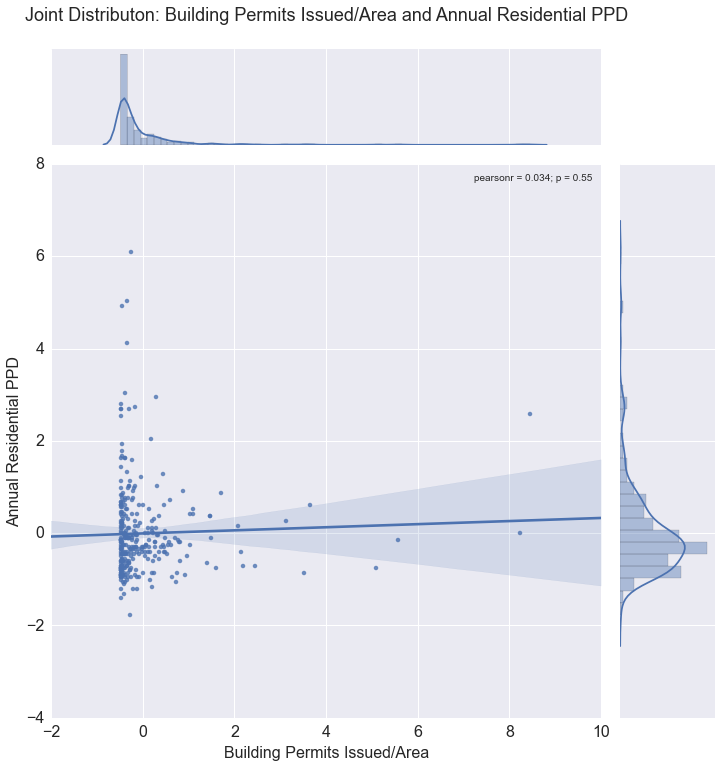

In [77]:
# Joint Distribution: Building Permits Issued/Area and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Permits/Area']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Permits/Area', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Building Permits Issued/Area', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Building Permits Issued/Area and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=red>Building Permits Issued/Person</font>

In [78]:
data['Permits/Person'] = data['Total_2013']/data['Population']

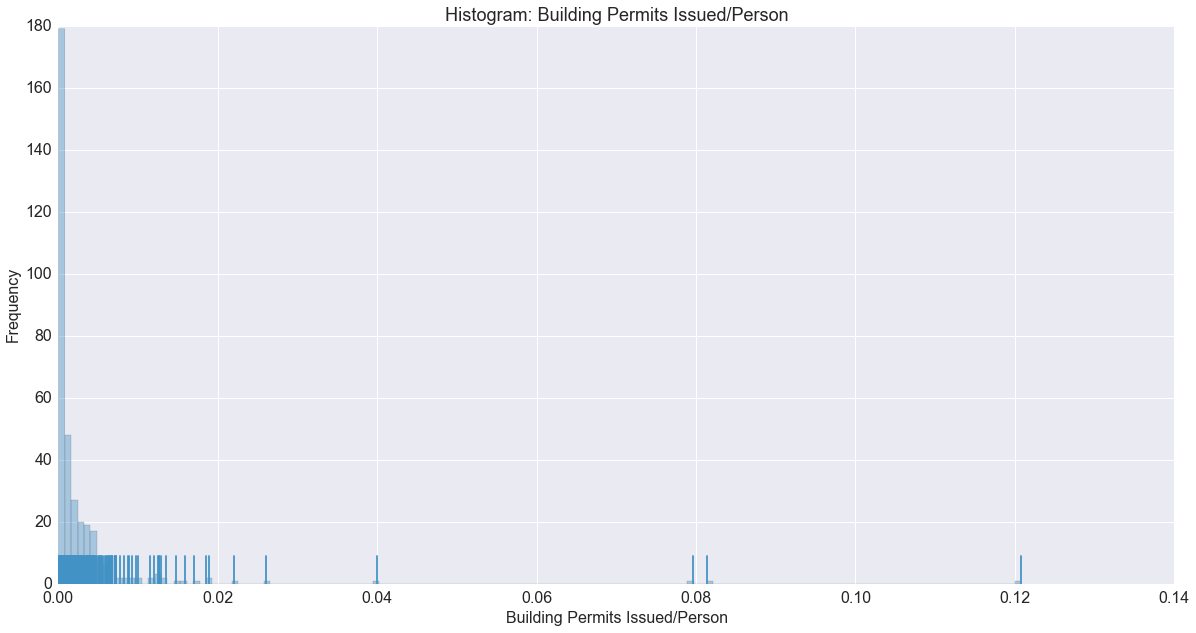

In [79]:
# Histogram: Building Permits Issued/Person
temp = data[['Permits/Person']] 

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#4292c6')
plt.xlabel('Building Permits Issued/Person', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Building Permits Issued/Person', fontsize = 18)

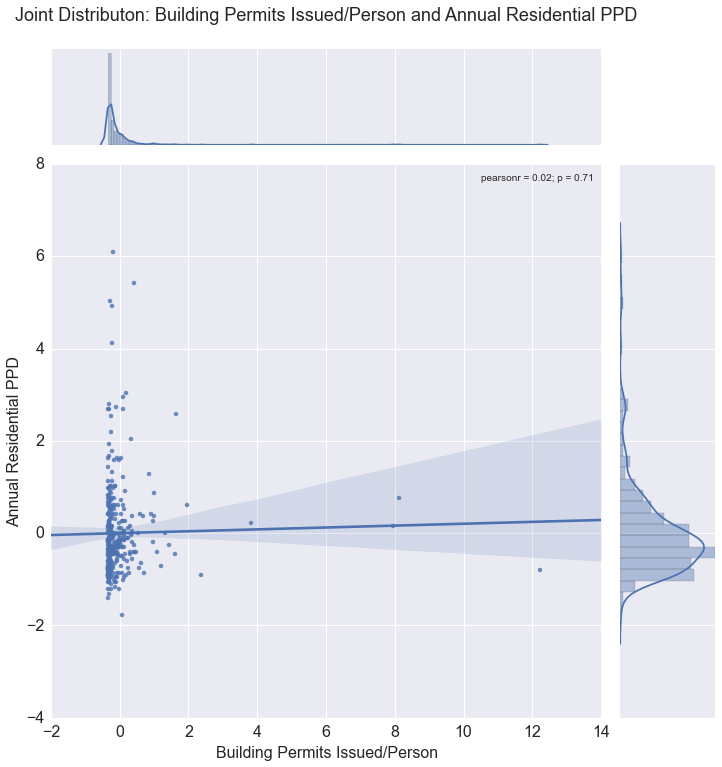

In [80]:
# Joint Distribution: Building Permits Issued/Person and Annual Residential PPD
temp = data[['Annual_ResPPD_2013', 'Permits/Person']]
temp = temp[(temp['Annual_ResPPD_2013'] < 20)] # Dropped outliers

# z-score Normalize 
temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

sns.jointplot('Permits/Person', 'Annual_ResPPD_2013', data = temp, kind = 'reg', size = 10)
plt.xlabel('Building Permits Issued/Person', fontsize = 16)
plt.ylabel('Annual Residential PPD', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Building Permits Issued/Person and Annual Residential PPD'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

## <font color=steelblue>Delete Unnecessary Columns</font> 

In [81]:
cols_to_keep = ['County', 'Jurisdiction', 'Target_ResPPD_2013', 'Annual_ResPPD_2013', 'Target_EmpPPD_2013', 'Annual_EmpPPD_2013',
               'Diversity_Index', 'Voter_Registration_Rate', 'Rep_Dem_Ratio', 'Major_Minor_Crime_Ratio', 'Percent_Violent', 
               'TotCrime/1000People', 'Crime_Index', 'HH_Income_Ratio', 'Fam_Income_Ratio', 'gMean_Income_Index',
               'PerCapitaIncome_Index', 'gMedian_Income_Index', 'MF_MedianEarnings_Index', 'Travel_Time_Index', 
               'Solar_ResUnits/HH', 'Solar_ResUnits/Person']


# Subtract 2 lists: Using list comprehension
#cols_to_del = [i for i in data.columns.tolist() if not i in cols_to_keep]

# Subtract 2 lists: Using set
cols_to_del = list(set(data.columns.tolist()) - set(cols_to_keep))

# Delete columns
for col in cols_to_del:
    del data[col]

In [82]:
# Location of columns in list and column names
for i, j in enumerate(data.columns.tolist()[:]):
    print i, '--->', j

0 ---> County
1 ---> Jurisdiction
2 ---> Target_ResPPD_2013
3 ---> Annual_ResPPD_2013
4 ---> Target_EmpPPD_2013
5 ---> Annual_EmpPPD_2013
6 ---> Diversity_Index
7 ---> Voter_Registration_Rate
8 ---> Rep_Dem_Ratio
9 ---> Major_Minor_Crime_Ratio
10 ---> Percent_Violent
11 ---> TotCrime/1000People
12 ---> Crime_Index
13 ---> HH_Income_Ratio
14 ---> Fam_Income_Ratio
15 ---> gMean_Income_Index
16 ---> PerCapitaIncome_Index
17 ---> Travel_Time_Index
18 ---> gMedian_Income_Index
19 ---> MF_MedianEarnings_Index
20 ---> Solar_ResUnits/Person
21 ---> Solar_ResUnits/HH


In [83]:
data.to_csv('feature_engineered_ankoor.csv', index = False)

In [84]:
print '# Rows: {}, and # Columns, {}'.format(data.shape[0], data.shape[1])

# Response variables, i.e. y
response = ['Annual_ResPPD_2013', 'Annual_EmpPPD_2013']

# Predictor variables or Features, i.e. x's
features = data.columns.tolist()

# Response-Predictor pairs
pairs = [(r, f) for r in response for f in features]

# Fill NaN with Median
temp = data
temp.fillna(temp.median(), inplace = True)

corr_calculation(temp, pairs, 'pearson', 0)

# Rows: 378, and # Columns, 22
**********************************************************************************************
Error count: "1". "Annual_ResPPD_2013" and "County" giving error: "unsupported operand type(s) for /: 'str' and 'int'"
**********************************************************************************************
**********************************************************************************************
Error count: "2". "Annual_ResPPD_2013" and "Jurisdiction" giving error: "unsupported operand type(s) for /: 'str' and 'int'"
**********************************************************************************************
Correlation between "Annual_ResPPD_2013" and "Target_ResPPD_2013" = 0.986763591082
-----------------------------------------------------------------------------------------------
Correlation between "Annual_ResPPD_2013" and "Annual_ResPPD_2013" = 1.0
----------------------------------------------------------------------------------------------

## Notes:

- Bivariate - Approach, try multivariate approach
- Boost the correlation by itself
- Residual - fit residual to second most correlated
- standardise variable and fit Multi-variate linear model
- Run regularized L-1 regression? Ridge or Lasso? shrinks the coeff to 0
- Jeff looking for jurisdiction that can improve/places that would be most impactful/places that could improve
- Grant from for google to do AD words to create a campaign/or online campagin to educate people about recycling and and teach people about recycling, animation quized, and after how recycling rates have changed
- More than 10? Jeff needs top 10 cities 
- List would be necessary
- Explanation on why a certain area is more likely than neighbor
- Correlation results

**Note**:
- Check this D3 tutorial later: http://code.hazzens.com/d3tut/lesson_4.html